In [1]:
# Randomly generate a set of points in 2D and give lavels to a small subset l of those points

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.metrics.pairwise import euclidean_distances
import time
import matplotlib.pyplot as plt
from tqdm import trange
import urllib.request
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import math
import os

In [2]:
# Set the directory where you want to save the figures
output_dir = r"/Users/Sofia/Desktop/Optimization_Homework/HW_Plots"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

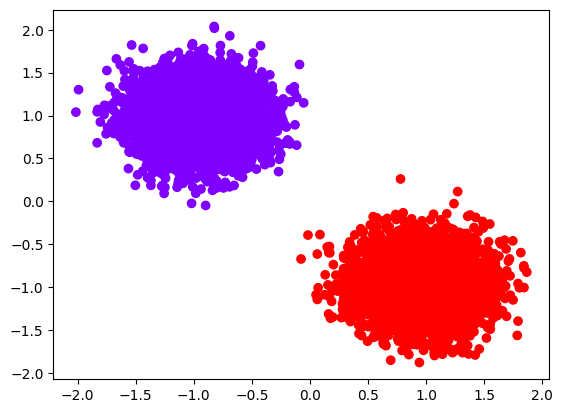

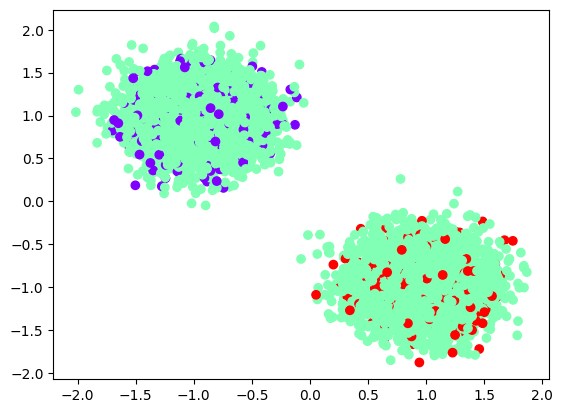

In [3]:
# Generate a dataset with 2 classes and clusters
X, y = make_blobs(n_samples=10000, centers=2, random_state=42)

# Reset the class labels from (y = 0,1) to (y = -1,1)
y[y == 0] = -1

#standardization 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Plot the points with different colors according to their labels before removing any labels
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
#plt.savefig(output_dir + "/Synthetic_Dataset_Original.png")
plt.show()

# Randomly remove 90% of labels
y_new = np.copy(y)
remove_idx = np.sort(np.random.choice(len(y), size=int(len(y)*90/100), replace=False))
y_unlabeled_target = y[remove_idx] # Save the removed labels for later use
y_new[remove_idx] = 0 # Set the removed labels to 0

# Split X into labeled (y = -1, 1) and unlabeled (y = 0) sets
labeled_idx = np.where(y_new != 0)
unlabeled_idx = np.where(y_new == 0)
x_labeled = X[labeled_idx]
x_unlabeled = X[unlabeled_idx]
y_labeled = y_new[labeled_idx]
y_unlabeled = y_new[unlabeled_idx]

# Plot the points with different colors according to their labels
plt.scatter(X[:, 0], X[:, 1], c=y_new, cmap='rainbow')
#plt.savefig(output_dir + "/Synthetic_Dataset_Labels_Removed.png")
plt.show()

In [4]:
print("x unlabeled:",x_unlabeled.shape)
print("x labeled :",x_labeled.shape)
print("y unlabeled:",y_unlabeled.shape)
print("y labeled",y_labeled.shape)

x unlabeled: (9000, 2)
x labeled : (1000, 2)
y unlabeled: (9000,)
y labeled (1000,)


#### Defining the similarity measure : gaussian weights 

The Gaussian similarity function between two vectors $x_1$ and $x_2$ is :
$$
K(x_1, x_2) = \exp\left(-\frac{||x_1 - x_2||^2}{2\sigma^2}\right)
$$

In [5]:
# Set the value of sigma to one of the values in the list,
# After testing for the different sigma values, we found that sigma = 0.3 yields the best results
sigma_values = [0.05, 0.1, 0.2, 0.3]
sigma = sigma_values[3]

In [6]:
# This function directly computes the similarity matrix
def gaussian_similarity(x1, x2, sigma):
    D = euclidean_distances(x1, x2, squared=True)
    S = np.exp(-D / (2.0 * sigma**2))
    return S

In [7]:
%%time
# similarity matrix labeled-unlabeled
w_labeled_unlabeled = gaussian_similarity(x_labeled, x_unlabeled,sigma=sigma)

# similarity matrix unlabeled-unlabeled
w_unlabeled_unlabeled = gaussian_similarity(x_unlabeled, x_unlabeled,sigma=sigma)

CPU times: user 2.36 s, sys: 979 ms, total: 3.34 s
Wall time: 2.56 s


In [8]:
print(w_labeled_unlabeled.shape) #we have 9000 rows because we have 9000 labeled data points and 1000 columns because we have 1000 unlabeled data points
print(w_unlabeled_unlabeled.shape)

(1000, 9000)
(9000, 9000)


Consider the problem $$\min_{y \in R^u} \left( \sum_{i=1}^l \sum_{j=1}^u w_{ij}(y_j - \bar{y}_i)^2 + \frac{1}{2}\sum_{i=1}^u \sum_{j=1}^u \bar{w}_{ij}(y_j-y_i)^2 \right)$$




In [9]:
# Define the Loss Function 
def loss(labeled, unlabeled):

    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))
    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * w_labeled_unlabeled.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * w_unlabeled_unlabeled.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

In [10]:
# Define the Accuracy Function
def accuracy(y_unlabeled_target, y_unlabeled_gradient):
    # Convert the predicted labels to -1 or 1 by thresholding at 0
    y_unlabeled_gradient_binary = np.where(y_unlabeled_gradient >= 0, 1, -1)
    
    # Calculate the accuracy by comparing the binary predicted labels with the true labels
    accuracy = np.mean(y_unlabeled_target == y_unlabeled_gradient_binary)
    
    return accuracy

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y_{j}}f(y) &= 2 \sum_{i=0}^lw_{ij}(y_{j} - \bar{y}_{i}) + 2 \sum_{i=0}^u\bar{w}_{ij}(y_{j} - y_{i}) \\
& = 2[( \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y_{j} -  \sum_{i=0}^lw_{ij}\bar{y}_{i} - \sum_{i=0}^u\bar{w}_{ij}y_{i}]
\end{align*}
$$

In [11]:
# Define the Gradient Coefficients and Gradient
sumbycol_label_unlabel = np.sum(w_labeled_unlabeled, axis=0).reshape((-1,1))
sumbycol_unlabel_unlabel = np.sum(w_unlabeled_unlabeled, axis=0).reshape((-1,1))
grad_first_term = 2 * (sumbycol_label_unlabel + sumbycol_unlabel_unlabel)
grad_second_term = 2 * np.multiply(y_labeled.reshape((-1,1)), w_labeled_unlabeled).sum(0).reshape((-1,1))

In [12]:
# Note that we can define the array of all the gradients with respect to the unlabeled vector 
def gradient_unlabeled(labeled, unlabeled):
    grads=[]
    for j in range(len(unlabeled)):
        grad=0
        for i in range(len(labeled)):
            grad+= 2* w_labeled_unlabeled[i][j]*(unlabeled[j]-labeled[i])
        for i in range(len(unlabeled)):
            grad+= 2* w_unlabeled_unlabeled[i][j]*(unlabeled[j]-unlabeled[i])
        grads.append(grad)
    return np.array(grads)

In [13]:
# Using the pre-defined constant vectors, we calculate the third term that depends on the unlabled vector in order to compute the expanded form of the gradient 
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_term = 2 * np.multiply(unlabeled,w_unlabeled_unlabeled).sum(0).reshape((-1,1))
    return (grad_first_term * unlabeled - grad_second_term - third_term).reshape((-1,))

Hessians and Lipschitz

In [14]:
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = 2 * np.copy(-w_unlabeled_unlabeled)
    for i in range(len(w_unlabeled_unlabeled)):
        mat[i][i] += 2 * (np.sum(w_labeled_unlabeled[:,i]) + np.sum(w_unlabeled_unlabeled[:,i]))
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]

In [15]:
# Compute the Hessian matrix
hessian = hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled)

In [16]:
# Estimate the Lipschitz constant for this sigma value
L = estimate_lipschitz_constant(hessian)
    
# Compute the step size
step_size = 1 / L

# Print the Lipschitz constant and step size
print(f"Sigma: {sigma}")
print(f"Estimate of Lipschitz constant: {L}")
print(f"Step size: {step_size}\n")

Sigma: 0.3
Estimate of Lipschitz constant: 5511.50247812168
Step size: 0.00018143872818157563



In [17]:
# Define a Lipschitz constant for each unlabeled data point
Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64')

### Gradient Descent Method

100%|██████████| 50/50 [04:30<00:00,  5.42s/it]



Final accuracy: 100.0%
F1-Score: 1.0
Confusion Matrix:
[[4503    0]
 [   0 4497]]
Norm gradient: 1146.256313006737
Loss: 1934.2413686542066



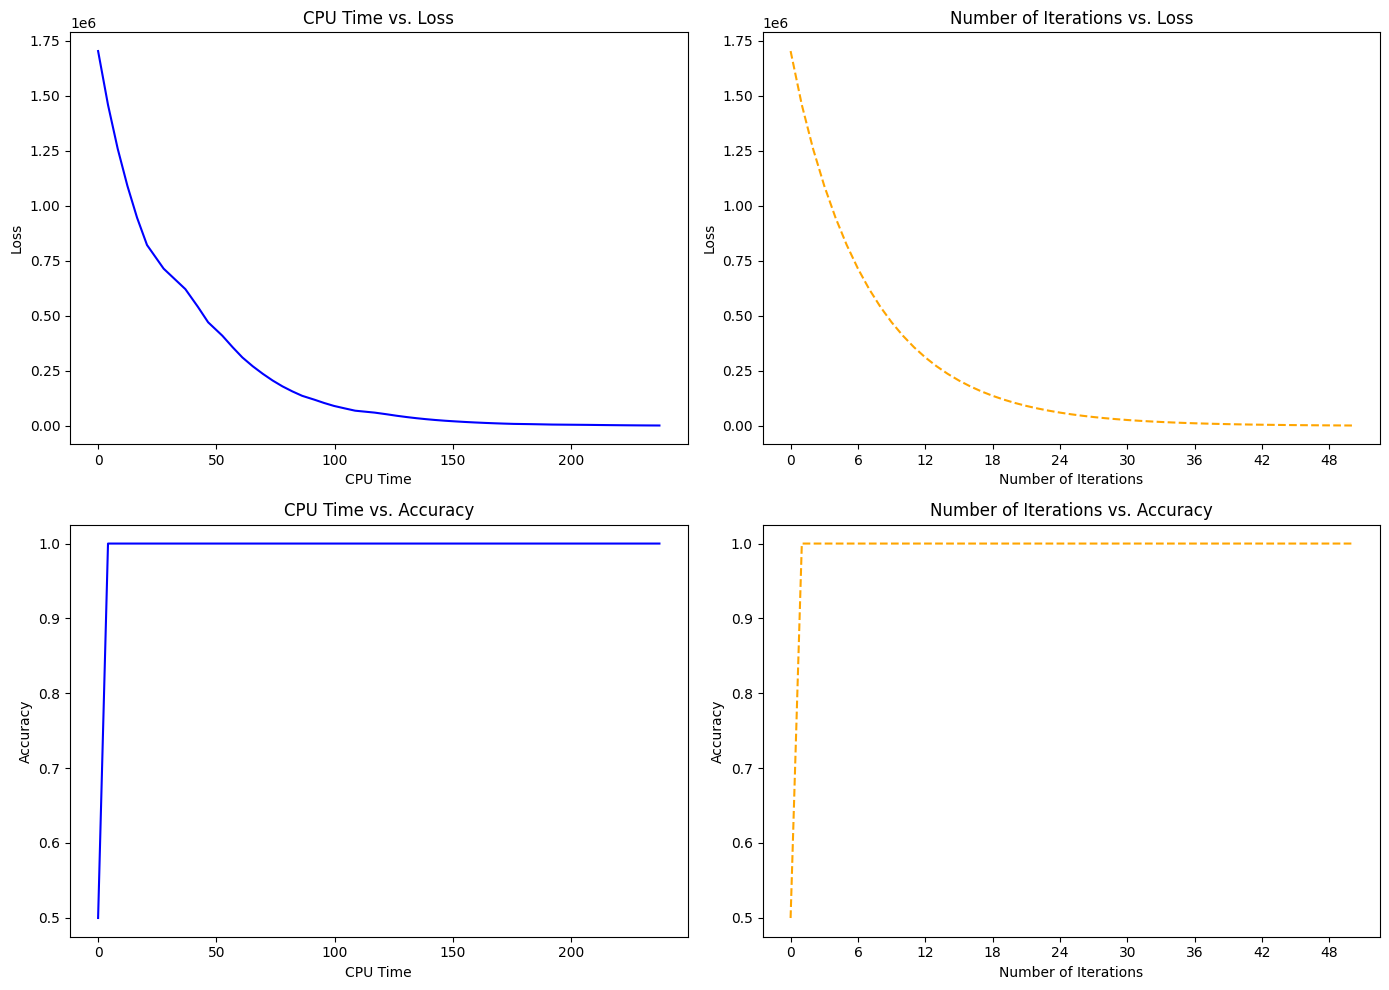

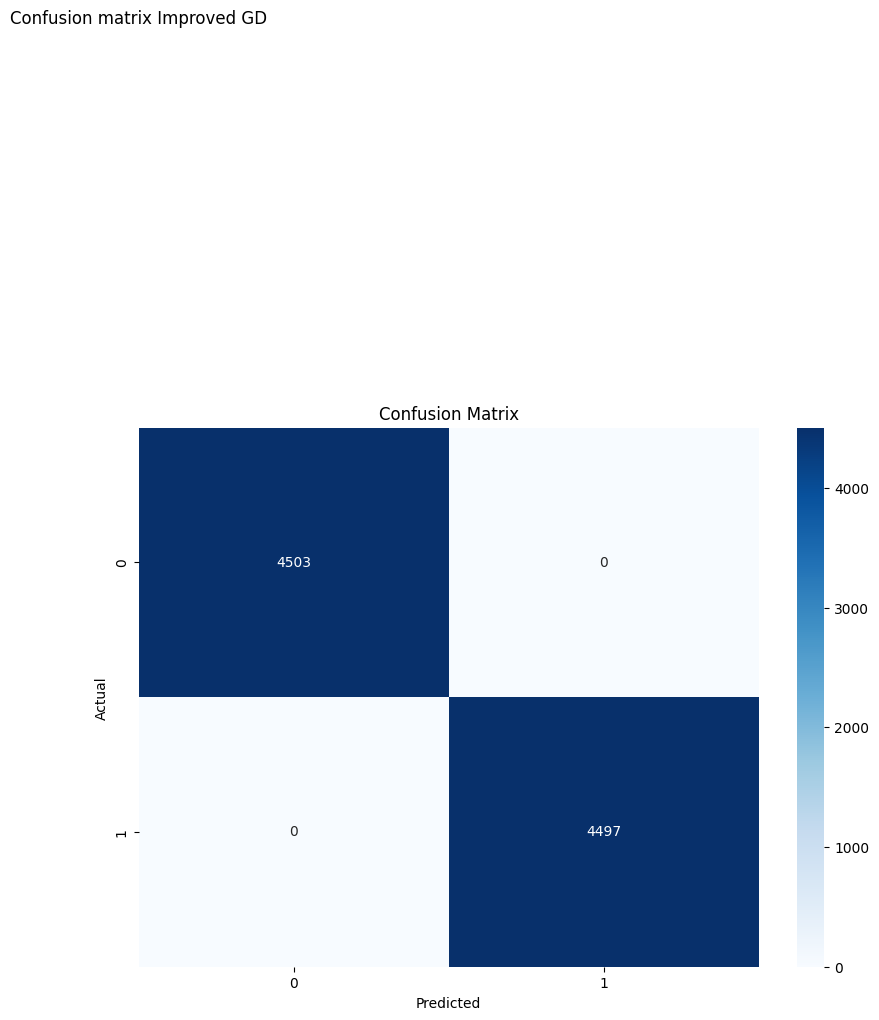

CPU times: user 2min 58s, sys: 1min 5s, total: 4min 4s
Wall time: 4min 39s


In [18]:
%%time

#Copy original unlabeled data
y_unlabeled_gd = np.copy(y_unlabeled).astype("float64")

current_time = time.strftime("%Y%m%d-%H%M%S")

num_iters = 50
epsilon = 1e-5
gd_accuracies = []
gd_losses = []
gd_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_gd)]
gd_losses = [loss(y_labeled, y_unlabeled_gd)]
cpu_times_gd = [0]

start_time_gd = time.process_time()  # Start measuring CPU time

for i in trange(num_iters):
    grad_array = gradient(y_unlabeled_gd)

    if epsilon >= np.linalg.norm(grad_array):
        print('We stopped at iteration{}'.format(i))
        break

    y_unlabeled_gd = y_unlabeled_gd - step_size * grad_array
    gd_accuracies.append(accuracy(y_unlabeled_target, y_unlabeled_gd))
    gd_losses.append(loss(y_labeled, y_unlabeled_gd))
    cpu_times_gd.append(time.process_time() - start_time_gd)  # Calculate elapsed CPU time for each iteration

y_unlabeled_gd_binary = np.where(y_unlabeled_gd >= 0, 1, -1)

print(f"""
Final accuracy: {round(gd_accuracies[-1] * 100, 2)}%
F1-Score: {f1_score(y_unlabeled_target, y_unlabeled_gd_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_gd_binary)}
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {gd_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_gd, gd_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(gd_losses)), gd_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_gd, gd_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(gd_accuracies)), gd_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"Gradient_Descent_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

# Calculate Confusion matrix
cm_gd = confusion_matrix(y_unlabeled_target, y_unlabeled_gd_binary, labels = [-1, 1])

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_gd, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix Improved GD', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"Gradient_Descent_Confusion_Matrix_{current_time}.png"))
plt.show()


In [19]:
print(y_unlabeled_gd)
print(y_unlabeled_target)

[ 0.97126197  0.9709088  -0.96960926 ... -0.96963227 -0.96880029
  0.96665064]
[ 1  1 -1 ... -1 -1  1]


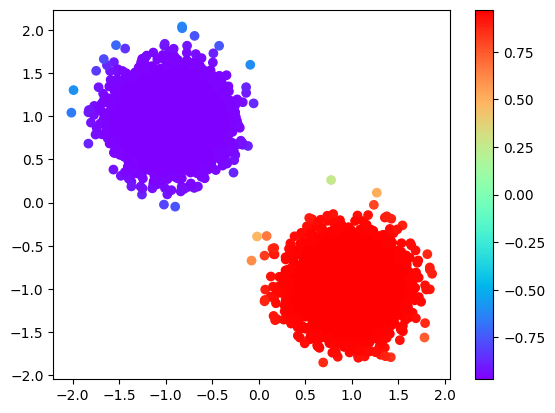

In [20]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_gd, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_GD_Training_y_unlabeled_gd.png")
plt.show()

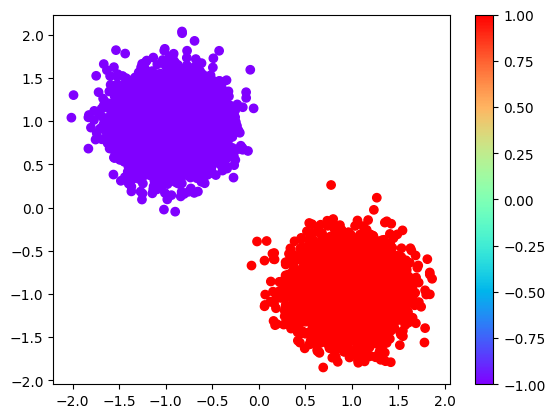

In [21]:
# Plot trained data against target
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_target, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_GD_Training_y_unlabeled_target.png")
plt.show()

### Momentum-based gradient descent : Heavy Ball

$x_{k+1} = x_k - \alpha_k \nabla f(x_k) + \beta_k (x_k - x_{k-1})$
where  $x_{k} − x_{k−1}$,
which is usually called momentum, nudges $x_{k+1}$ in the direction of the previous
step

100%|██████████| 50/50 [05:15<00:00,  6.31s/it]



Final accuracy: 100.0%
F1 Score: 1.0
Confusion Matrix:
[[4503    0]
 [   0 4497]]
Norm gradient: 492.27639582848326
Loss: 321.4994609684367



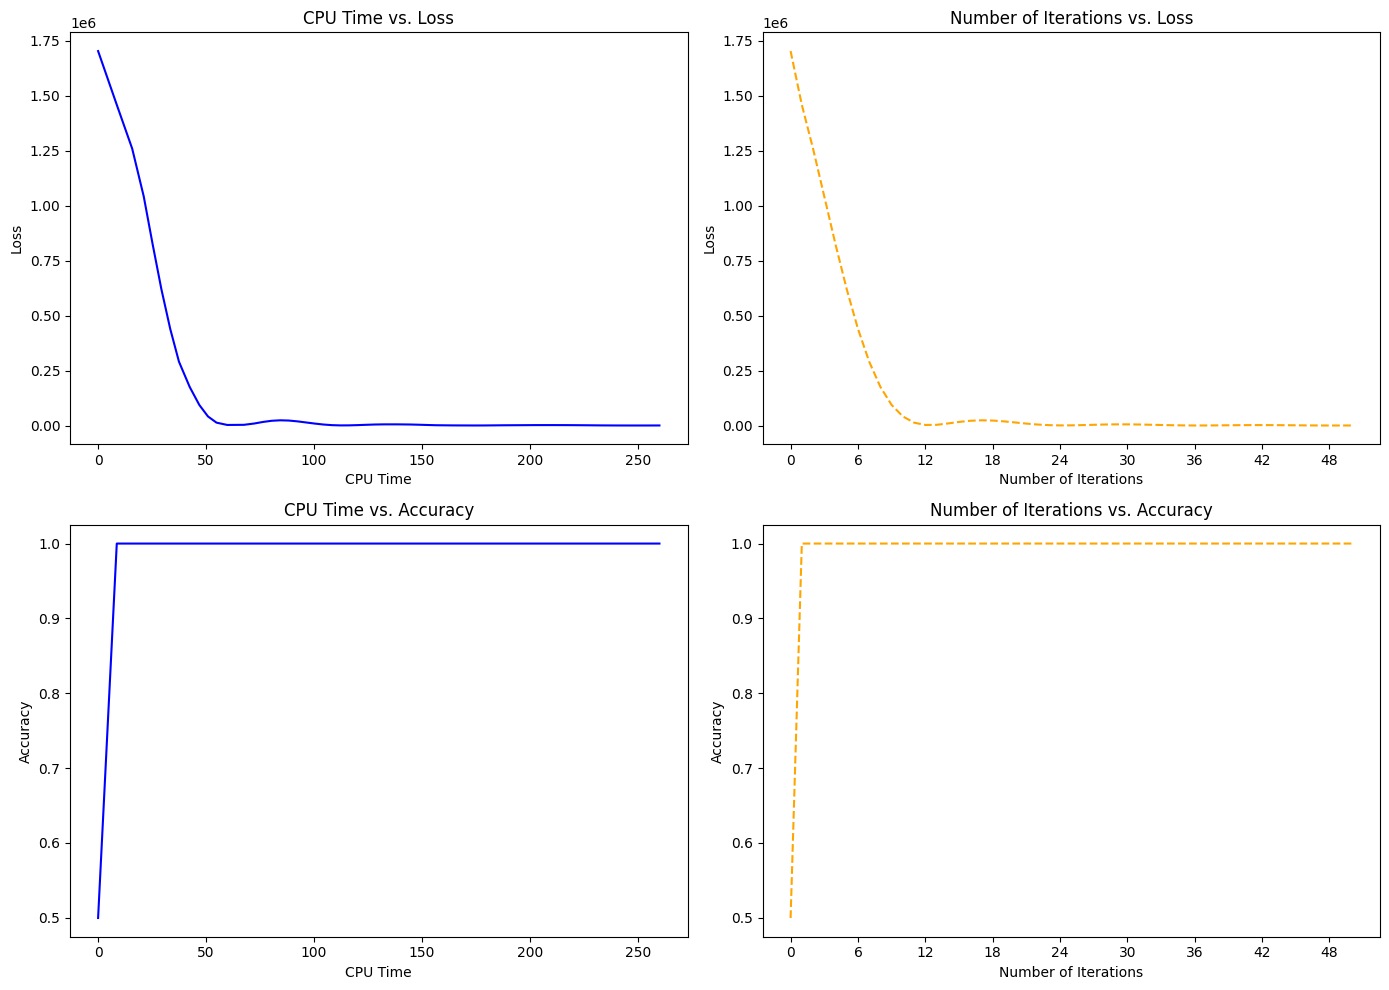

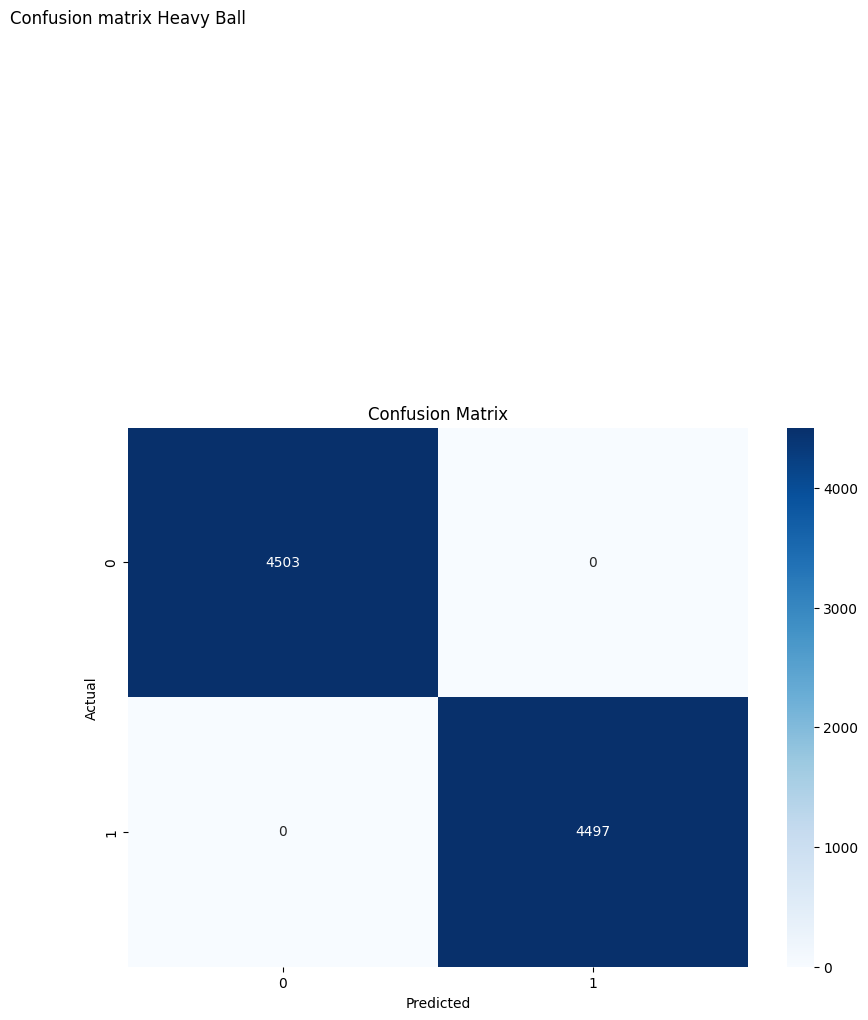

CPU times: user 3min 5s, sys: 1min 24s, total: 4min 29s
Wall time: 5min 37s


In [22]:
%%time

# Copy original unlabeled data
y_unlabeled_hb_previous = y_unlabeled_hb = np.copy(y_unlabeled)

current_time = time.strftime("%Y%m%d-%H%M%S")

step_size = step_size
num_iters = 50
epsilon = 1e-5
hb_accuracies = []
hb_losses = []
hb_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_hb)]
hb_losses = [loss(y_labeled, y_unlabeled_hb)]
hb_cpu_times = [0]

start_time = time.process_time()  # Start measuring CPU time
lambda_ = 0

for i in trange(num_iters):
    grad_array = gradient(y_unlabeled_hb)

    if epsilon >= np.linalg.norm(grad_array):
        print('We stopped at iteration{}'.format(i))
        break

    new_lambda_ = (1 + math.sqrt(1 + 4 * lambda_**2))/2
    Beta = (lambda_ - 1) / new_lambda_
    lambda_ = new_lambda_
    momentum = Beta * (y_unlabeled_hb - y_unlabeled_hb_previous)

    old_y_unlabeled_hb = np.copy(y_unlabeled_hb)
    y_unlabeled_hb = y_unlabeled_hb - step_size * grad_array + momentum
    y_unlabeled_hb_previous = old_y_unlabeled_hb

    hb_accuracies.append(accuracy(y_unlabeled_target, y_unlabeled_hb))
    hb_losses.append(loss(y_labeled, y_unlabeled_hb))
    hb_cpu_times.append(time.process_time() - start_time)  # Calculate elapsed CPU time for each iteration

# Compute accuracy score, f1 score and confusion matrix
accuracy_score = accuracy(y_unlabeled_target, y_unlabeled_hb)

y_unlabeled_hb_binary = np.where(y_unlabeled_hb >= 0, 1, -1)

print(f"""
Final accuracy: {round(accuracy_score * 100, 2)}%
F1 Score: {f1_score(y_unlabeled_target, y_unlabeled_hb_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_hb_binary)}
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_hb))}
Loss: {hb_losses[-1]}
""")

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

axs[0, 0].plot(hb_cpu_times, hb_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

axs[0, 1].plot(range(len(hb_losses)), hb_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axs[1, 0].plot(hb_cpu_times, hb_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

axs[1, 1].plot(range(len(hb_accuracies)), hb_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"Heavy_Ball_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

plt.tight_layout()
plt.show()

# Calculate Confusion matrix
cm_hb = confusion_matrix(y_unlabeled_target, y_unlabeled_hb_binary)

plt.figure(figsize=(10,7))
sns.heatmap(cm_hb, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix Heavy Ball', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"Heavy_Ball_Confusion_Matrix_{current_time}.png"))
plt.show()

In [23]:
print(y_unlabeled_hb)
print(y_unlabeled_target)

[ 0.9886401   0.98854216 -0.98999352 ... -0.98999065 -0.98972664
  0.98765434]
[ 1  1 -1 ... -1 -1  1]


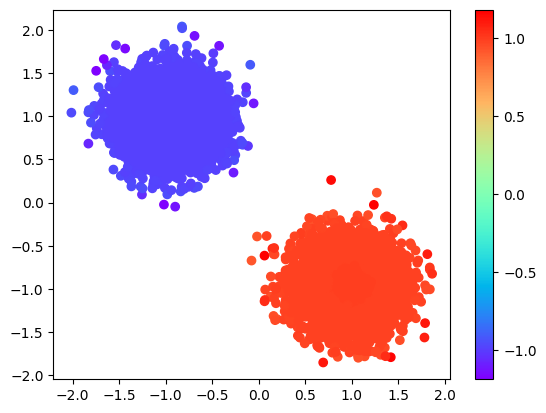

In [24]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_hb, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_HB_Training_y_unlabeled_hb.png")
plt.show()

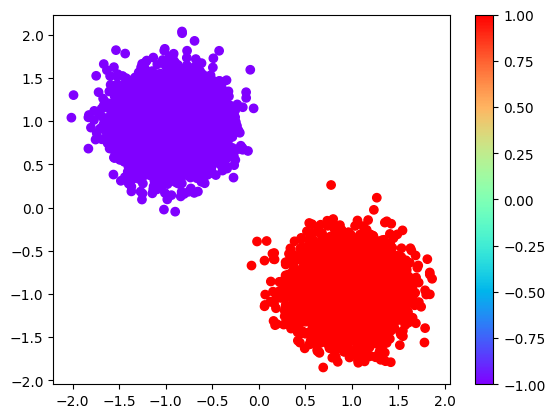

In [25]:
# Plot trained data against target
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_target, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_HB_Training_y_unlabeled_target.png")
plt.show()

### Block Coordinate Gradient Method: Randomized

100%|██████████| 450000/450000 [08:04<00:00, 929.32it/s] 



Final accuracy: 99.98%
F1 Score: 0.9997776789684304
Confusion Matrix:
[[4501    2]
 [   0 4497]]
Norm gradient: 644.2746515963511
Loss: 739.3357109027136



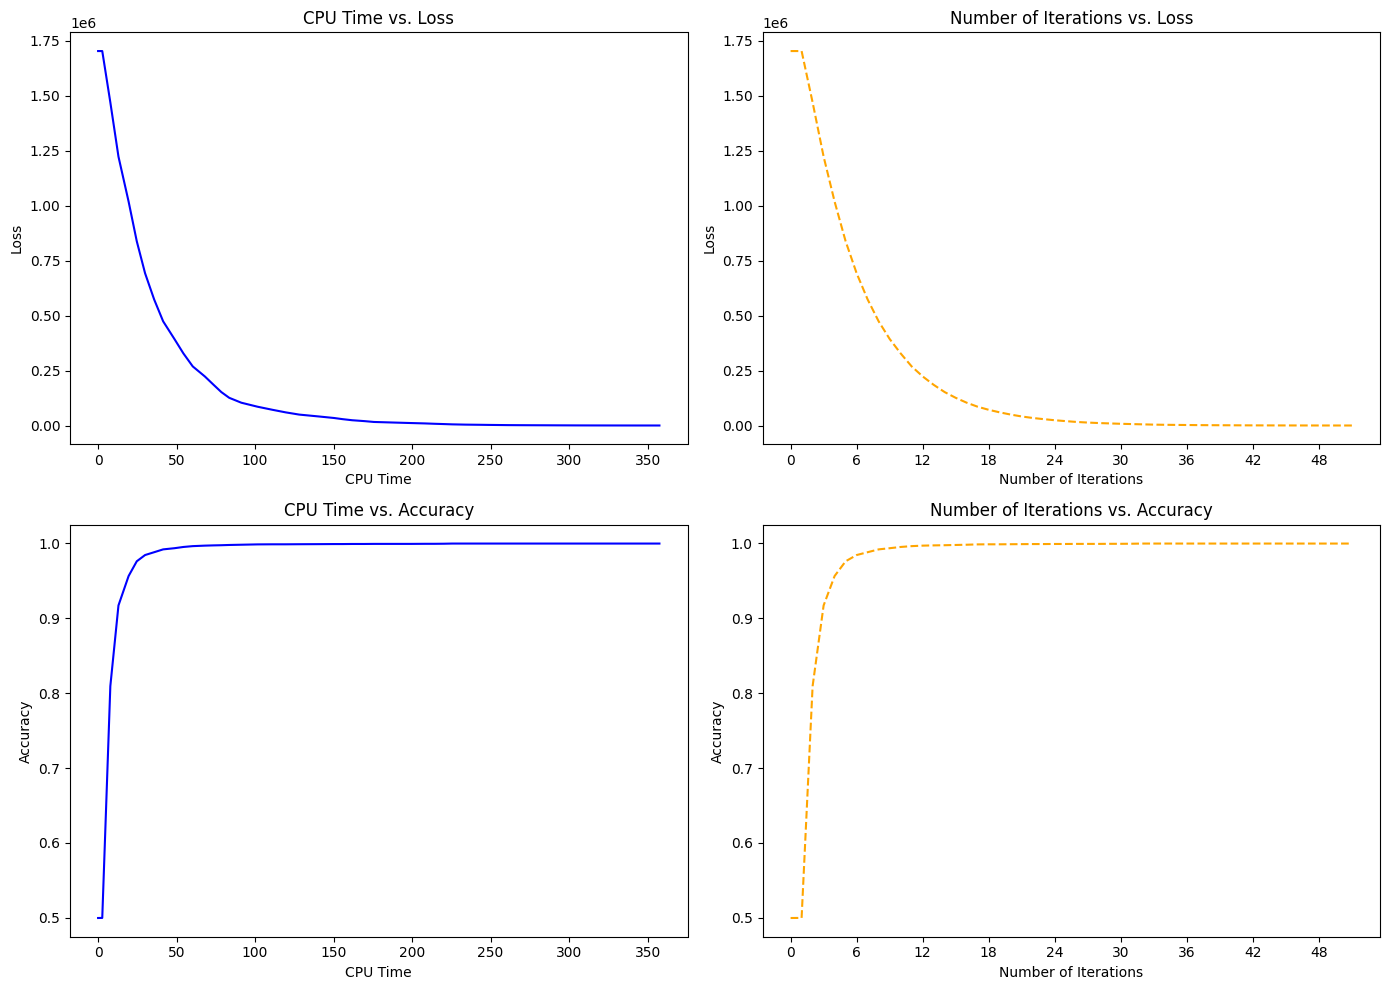

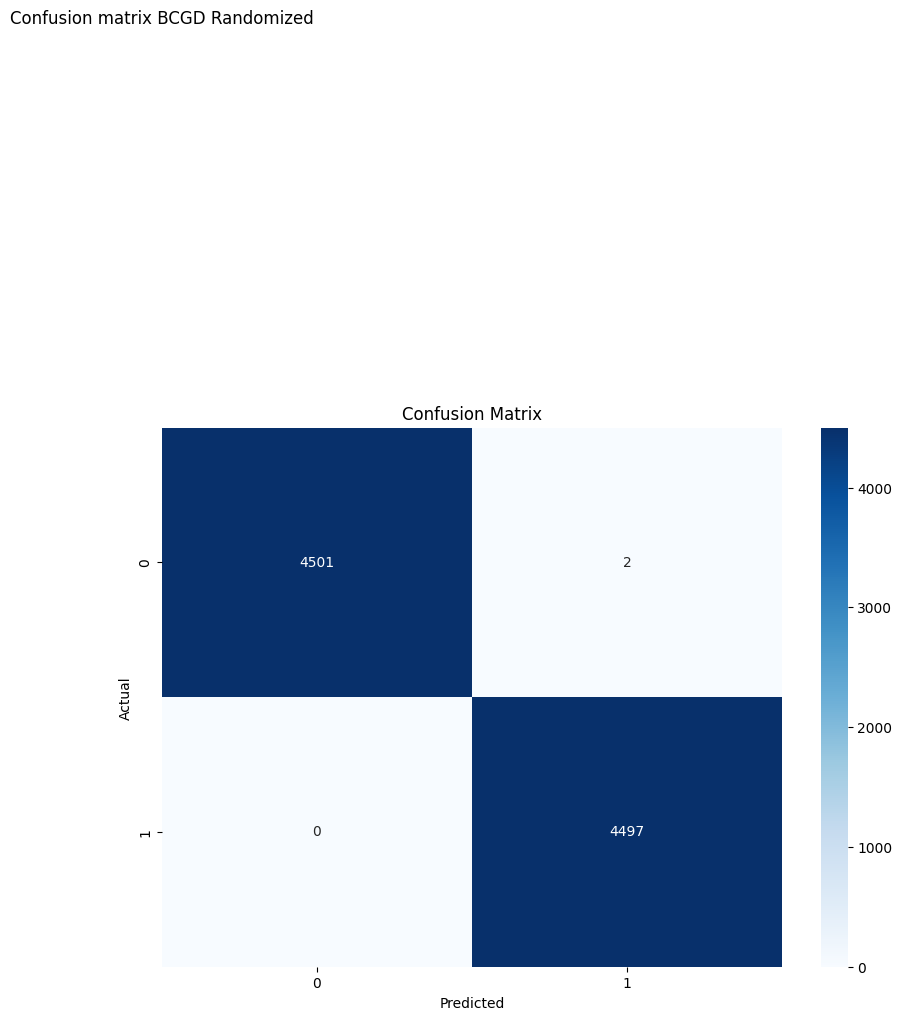

CPU times: user 4min 18s, sys: 1min 45s, total: 6min 4s
Wall time: 8min 16s


In [26]:
%%time

# Make a copy of the unlabeled data
y_unlabeled_bcgd_random = np.copy(y_unlabeled).astype(np.float64)
current_time = time.strftime("%Y%m%d-%H%M%S")
max_iter = num_iters * len(y_unlabeled_bcgd_random)

# Define the improved probability measure using the array of Lipschitz constants
improved_prob = Li / np.sum(Li)

grad_bcgd_rand = gradient(y_unlabeled_bcgd_random)
bcgd_rand_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)]
bcgd_rand_losses = [loss(y_labeled, y_unlabeled_bcgd_random)]

# Select a random index according to the improved probability measure
indices = np.random.choice(len(y_unlabeled_bcgd_random), max_iter, p=improved_prob)

start_time_bcgd_rand = time.process_time()  # Start measuring CPU time
cpu_times_bcgd_rand = [0]
for i in trange(max_iter):
    
    j = indices[i]
    
    # Calculate the gradient at the unlabeled data point with index j
    grad_j = grad_first_term[j] * y_unlabeled_bcgd_random[j] - \
             grad_second_term[j] - \
             2 * np.matmul(w_unlabeled_unlabeled[:,j], y_unlabeled_bcgd_random.T)

    # Replace the gradient of index j in the original gradient array
    grad_bcgd_rand[j] = grad_j

    # Update the unlabeled data point with index j
    y_unlabeled_bcgd_random[j] -= grad_j[0] / (Li[j])
    
    # Calculate accuracy and loss at each full length iteration
    if i % len(y_unlabeled_target) == 0:
        acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)
        loss_val = loss(y_labeled, y_unlabeled_bcgd_random)
        bcgd_rand_accuracies.append(acc)
        bcgd_rand_losses.append(loss_val)
        cpu_times_bcgd_rand.append(time.process_time() - start_time_bcgd_rand)

    # Check stopping condition
    grad_norm_rand = np.linalg.norm(grad_bcgd_rand)
    if grad_norm_rand <= epsilon:
        print(f"We stopped at iteration {i}")
        break

acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)
loss_val = loss(y_labeled, y_unlabeled_bcgd_random)
bcgd_rand_accuracies.append(acc)
bcgd_rand_losses.append(loss_val)
cpu_times_bcgd_rand.append(time.process_time() - start_time_bcgd_rand)  # Calculate elapsed CPU time for each iteration

y_unlabeled_bcgd_rand_binary = np.where(y_unlabeled_bcgd_random >= 0, 1, -1)

print(f"""
Final accuracy: {round(bcgd_rand_accuracies[-1] * 100, 2)}%
F1 Score: {f1_score(y_unlabeled_target,y_unlabeled_bcgd_rand_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_rand_binary)}
Norm gradient: {grad_norm_rand}
Loss: {bcgd_rand_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_bcgd_rand, bcgd_rand_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(bcgd_rand_losses)), bcgd_rand_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_bcgd_rand, bcgd_rand_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(bcgd_rand_accuracies)), bcgd_rand_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"BCGD_Randomized_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

# Calculate Confusion matrix
cm_bcgd_rand = confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_rand_binary)

plt.figure(figsize=(10,7))
sns.heatmap(cm_bcgd_rand, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix BCGD Randomized', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"BCGD_Randomized_Confusion_Matrix_{current_time}.png"))
plt.show()

In [27]:
print(y_unlabeled_bcgd_random)
print(y_unlabeled_target)

[ 0.99314385  0.99253721 -0.99240933 ... -0.99242055 -0.99216108
  0.99074102]
[ 1  1 -1 ... -1 -1  1]


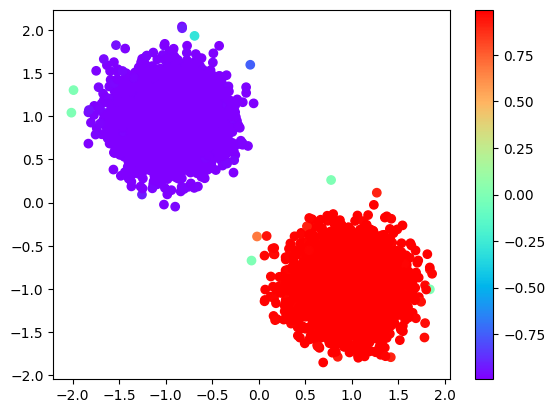

In [28]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_bcgd_random, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_bcgd_random_Training_y_unlabeled_bcgd_rand.png")
plt.show()

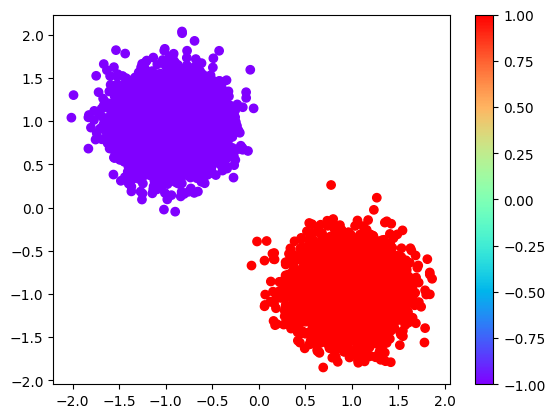

In [29]:
# Plot trained data against target
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_target, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_bcgd_random_Training_y_unlabeled_target.png")
plt.show()

### Block Coordinate Gradient Method: Gauss-Southwell

In [30]:
#copy the unlabeled data to a new y_unlabeled_bcgd-gs array 
y_unlabeled_bcgd_gs = np.copy(y_unlabeled).astype("float64")

In [31]:
#def a function that returns the update step and the new gradient for each iteration 
def bcgd_gs_gradient(previous_grad, index, Li):
    update_step = 1/Li[index] * previous_grad[index]
    bcgd_gs_grad = np.copy(previous_grad)
    bcgd_gs_grad += 2 * w_unlabeled_unlabeled[index] * update_step
    bcgd_gs_grad[index] -= grad_first_term[index] * update_step
    return update_step, bcgd_gs_grad

100%|██████████| 450000/450000 [05:55<00:00, 1266.68it/s]



Final accuracy: 100.0%
F1 Score: 1.0
Confusion Matrix:
[[4503    0]
 [   0 4497]]
Norm gradient: 1.2927692823475339
Loss: 5.967678316879983



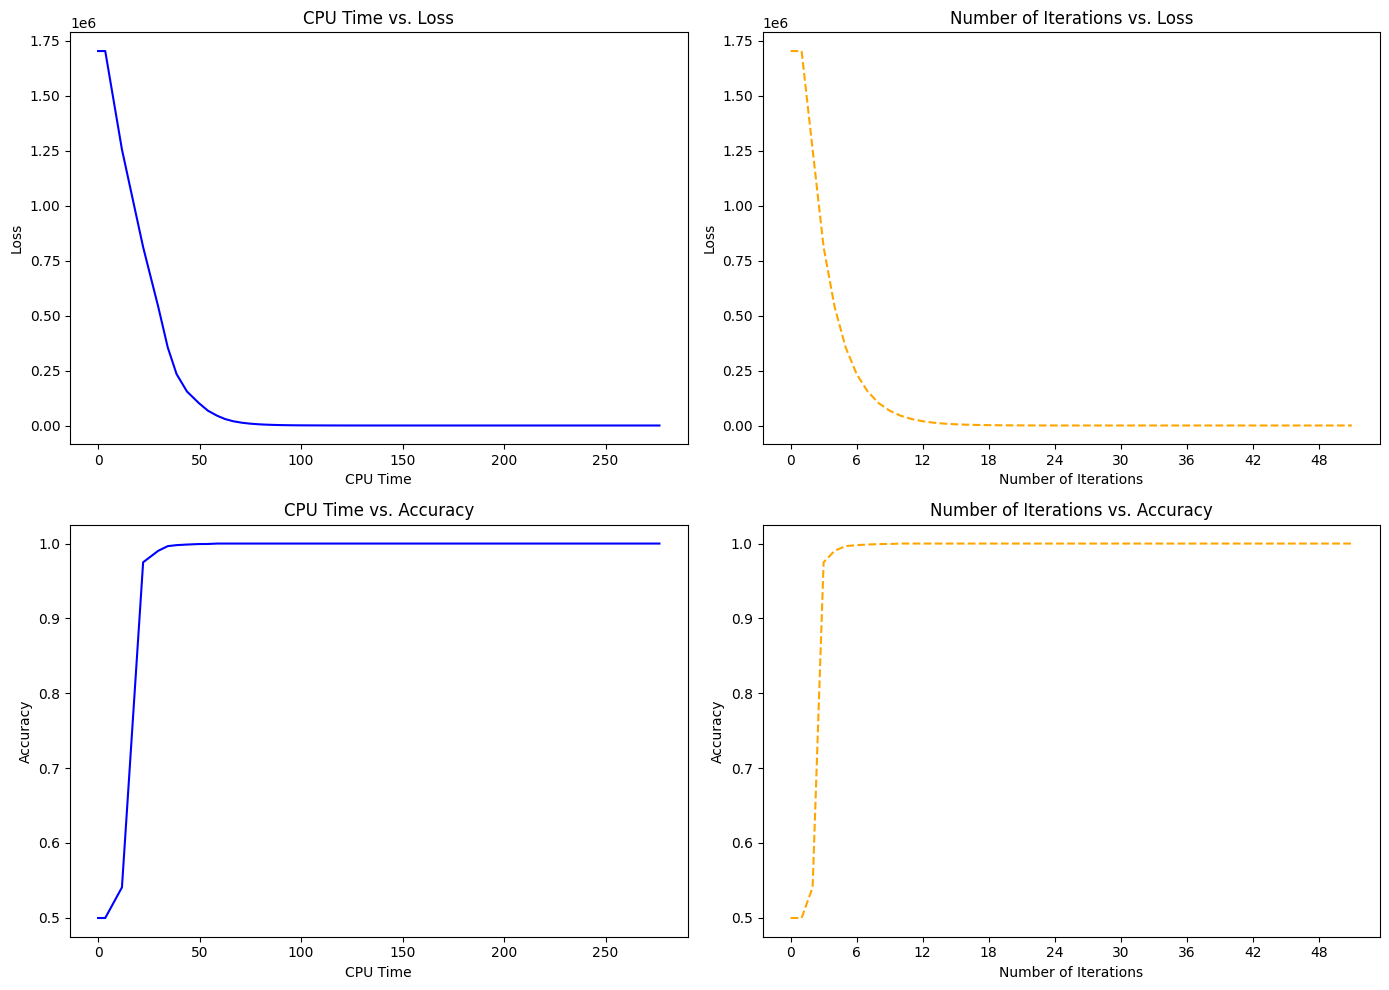

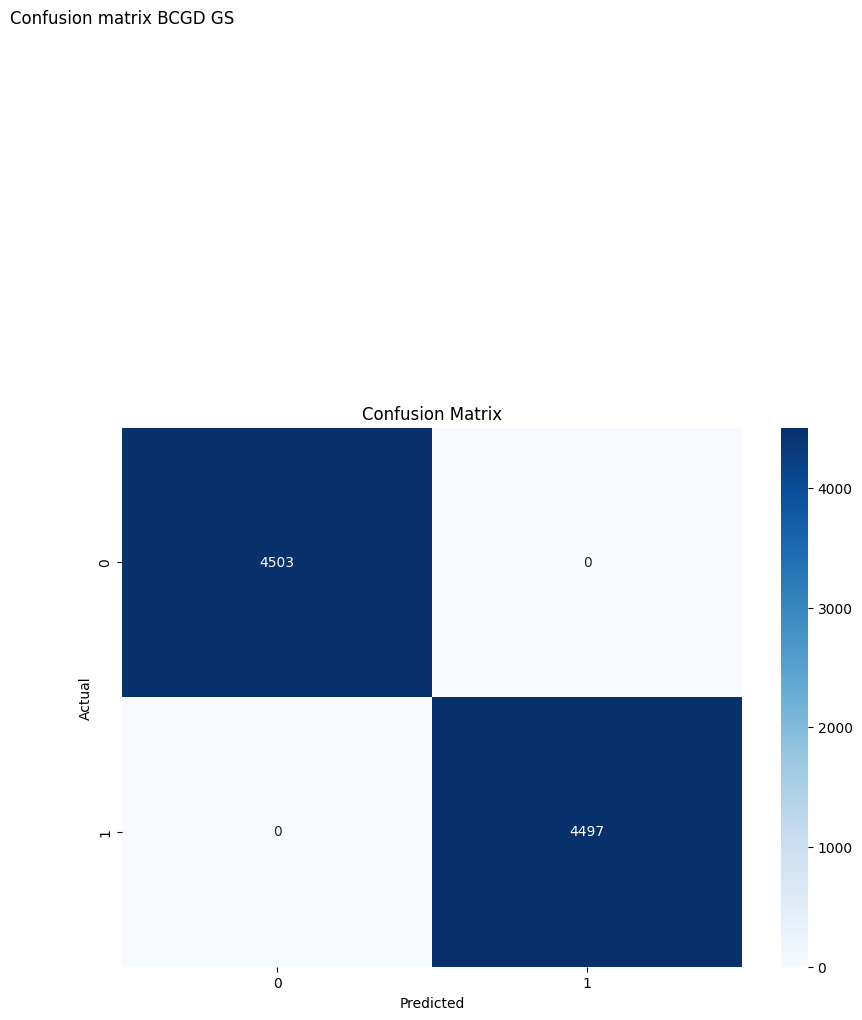

CPU times: user 3min 20s, sys: 1min 22s, total: 4min 42s
Wall time: 6min 7s


In [32]:
%%time

current_time = time.strftime("%Y%m%d-%H%M%S")

bcgd_gs_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_bcgd_gs)]
bcgd_gs_losses = [loss(y_labeled, y_unlabeled_bcgd_gs)]
num_iters = 50
max_iter = num_iters*len(y_unlabeled_bcgd_gs)
bcgd_gs_grad_prev= gradient(y_unlabeled_bcgd_gs)

start_time_bcgd_gs = time.process_time()  # Start measuring CPU time
cpu_times_bcgd_gs = [0]

for i in trange(max_iter):

    # Select index 
    index = np.argmax(np.abs(bcgd_gs_grad_prev))

    update_step, bcgd_gs_grad =bcgd_gs_gradient(bcgd_gs_grad_prev, index, Li)
    
    y_unlabeled_bcgd_gs[index] =y_unlabeled_bcgd_gs[index] - update_step
    bcgd_gs_grad_prev=bcgd_gs_grad

    # Calculate accuracy and loss at each full length iteration
    if i % len(y_unlabeled_target) == 0:
        acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_gs)
        loss_val = loss(y_labeled, y_unlabeled_bcgd_gs)
        bcgd_gs_accuracies.append(acc)
        bcgd_gs_losses.append(loss_val)
        cpu_times_bcgd_gs.append(time.process_time() - start_time_bcgd_gs)

    grad_norm_gs = np.linalg.norm(bcgd_gs_grad_prev)
    if epsilon >= grad_norm_gs:
        print('We stopped at iteration{}'.format(i))
        break

acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_gs)
loss_val = loss(y_labeled, y_unlabeled_bcgd_gs)
bcgd_gs_accuracies.append(acc)
bcgd_gs_losses.append(loss_val)
cpu_times_bcgd_gs.append(time.process_time() - start_time_bcgd_gs)  # Calculate elapsed CPU time for each iteration

y_unlabeled_bcgd_gs_binary = np.where(y_unlabeled_bcgd_gs >= 0, 1, -1)

print(f"""
Final accuracy: {round(bcgd_gs_accuracies[-1] * 100, 2)}%
F1 Score: {f1_score(y_unlabeled_target,y_unlabeled_bcgd_gs_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_gs_binary)}
Norm gradient: {grad_norm_gs}
Loss: {bcgd_gs_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_bcgd_gs, bcgd_gs_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(bcgd_gs_losses)), bcgd_gs_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_bcgd_gs, bcgd_gs_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(bcgd_gs_accuracies)), bcgd_gs_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"BCGD_GS_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

# Calculate Confusion matrix
cm_bcgd_gs = confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_gs_binary)

plt.figure(figsize=(10,7))
sns.heatmap(cm_bcgd_gs, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix BCGD GS', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"BCGD_GS_Confusion_Matrix_{current_time}.png"))
plt.show()

In [33]:
print(y_unlabeled_bcgd_gs)
print(y_unlabeled_target)

[ 0.99996872  0.99996602 -0.99996507 ... -0.99996489 -0.99996499
  0.9999594 ]
[ 1  1 -1 ... -1 -1  1]


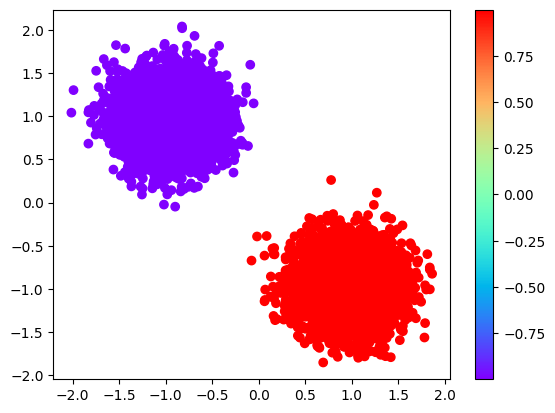

In [34]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_bcgd_gs, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_bcgd_gs_Training_y_unlabeled_bcgd_gs.png")
plt.show()

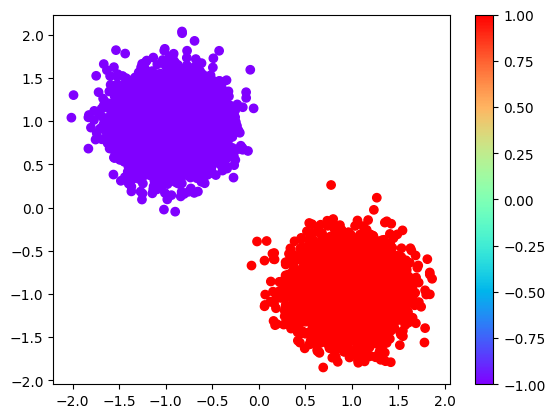

In [35]:
# Plot trained data against target
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_target, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Synthetic_Dataset_Post_bcgd_gs_Training_y_unlabeled_target.png")
plt.show()

### Compare all the models

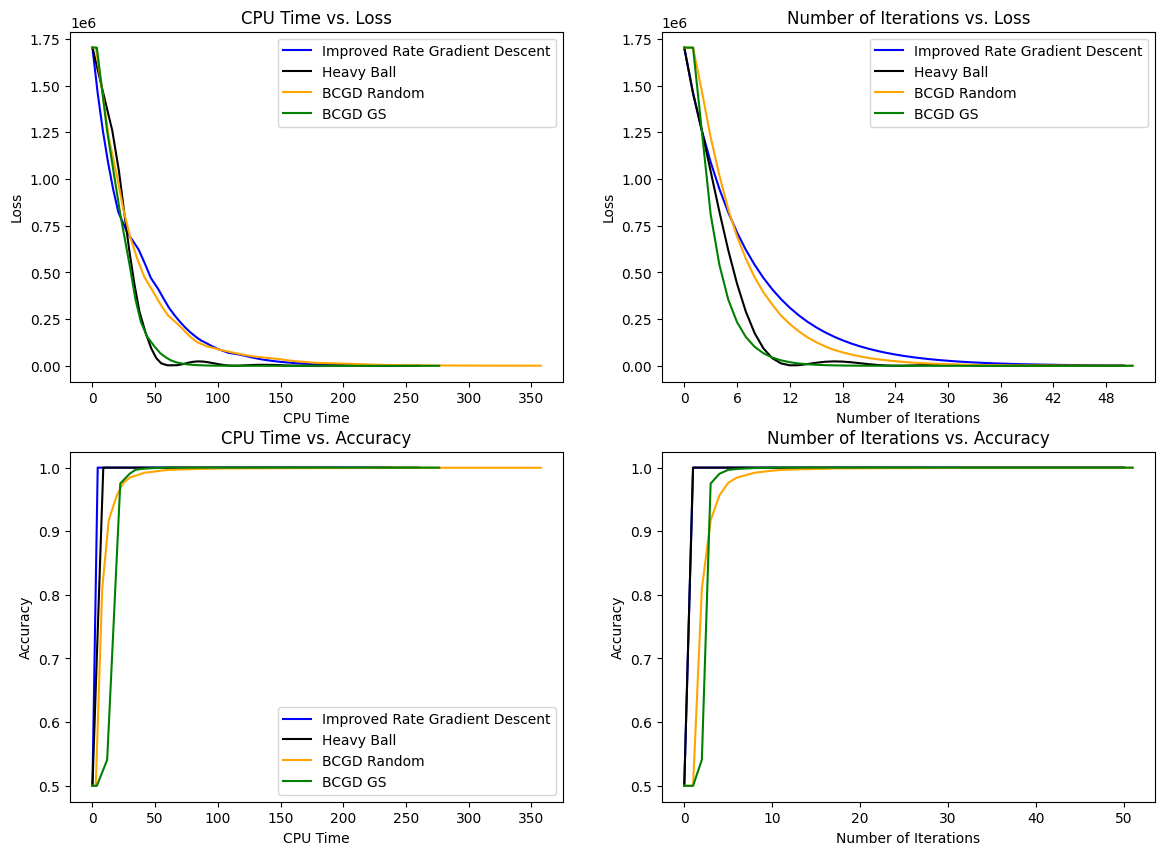

In [36]:
# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color_gd = "blue"
color_hb = "black"
color_bcgd_rand = "orange"
color_bcgd_gs = "green"
linestyle1 = '-'    # Solid line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_gd, gd_losses, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[0, 0].plot(hb_cpu_times, hb_losses, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[0, 0].plot(cpu_times_bcgd_rand, bcgd_rand_losses, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[0, 0].plot(cpu_times_bcgd_gs, bcgd_gs_losses, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')
axs[0, 0].legend()

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(gd_losses)), gd_losses, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[0, 1].plot(range(len(hb_losses)), hb_losses, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[0, 1].plot(range(len(bcgd_rand_losses)), bcgd_rand_losses, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[0, 1].plot(range(len(bcgd_gs_losses)), bcgd_gs_losses, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0, 1].legend()

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_gd, gd_accuracies, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[1, 0].plot(hb_cpu_times, hb_accuracies, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[1, 0].plot(cpu_times_bcgd_rand, bcgd_rand_accuracies, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[1, 0].plot(cpu_times_bcgd_gs, bcgd_gs_accuracies, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')
axs[1, 0].legend()

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(gd_accuracies)), gd_accuracies, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[1, 1].plot(range(len(hb_accuracies)), hb_accuracies, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[1, 1].plot(range(len(bcgd_rand_accuracies)), bcgd_rand_accuracies, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[1, 1].plot(range(len(bcgd_gs_accuracies)), bcgd_gs_accuracies, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis
#fig.savefig(os.path.join(output_dir, f"Synthetic_Dataset_Compare_All_Models_{num_iters}_sigma_{sigma}_{current_time}.png"))


plt.show()

### Test on a real dataset: skin segmentation for melanoma

In [37]:
# Download the Skin Segmentation dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
filename = 'Skin_NonSkin.txt'
urllib.request.urlretrieve(url, filename)

# Load the dataset using NumPy
data = np.loadtxt(filename, dtype=np.uint8, delimiter='\t')

#### Information about the dataset

The Skin Segmentation Dataset is a binary classification dataset that contains information about skin segments and whether they are melanoma or not. The dataset was created to aid in the early detection of melanoma, which is a type of skin cancer that can be fatal if not detected early.

The dataset contains a total of 245,057 instances, with approximately 6,000 instances labeled as positive examples (melanoma) and the remaining instances labeled as negative examples (non-melanoma). Each instance in the dataset consists of three continuous-valued features, which are derived from the RGB color space of the skin segment.

The features in the dataset include the red, green, and blue color values for each pixel in the skin segment. The dataset also includes a binary label indicating whether the skin segment is melanoma or not.

The dataset was created by the Laboratory of Artificial and Natural Intelligence at the University of Porto, and is available as part of the UCI Machine Learning Repository. It was originally used in their paper "Human skin color clustering for face detection".

#### Load the Skin Segmentation dataset from scikit-learn and extract 10,000 balanced instances

In [38]:
# Extract the feature and target data
X = data[:, :-1]
y = data[:, -1]

print("The dimensions of X are: {}".format(X.shape))
print("The dimensions of y are: {}".format(y.shape))

# Get the indices of positive and negative examples
pos_idx = np.where(y == 1)[0]
neg_idx = np.where(y == 2)[0]

# Shuffle the indices to get random samples
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)

# Get the first 5000 positive and negative examples
pos_idx = pos_idx[:5000]
neg_idx = neg_idx[:5000]

# Concatenate the positive and negative examples
idx = np.concatenate([pos_idx, neg_idx])

# Shuffle the indices again to mix positive and negative examples
np.random.shuffle(idx)

# Use the selected indices to extract the balanced subset of data
X_balanced = X[idx]
y_balanced = y[idx]

# Take the first 10000 instances
X_balanced = X_balanced[:10000]
y_balanced = y_balanced[:10000]

X = X_balanced.astype(np.float64)
y = y_balanced.astype(np.float64)

print("The dimensions of X_balanced are: {}".format(X_balanced.shape))
print("The dimensions of y_balanced are: {}".format(y_balanced.shape))

The dimensions of X are: (245057, 3)
The dimensions of y are: (245057,)
The dimensions of X_balanced are: (10000, 3)
The dimensions of y_balanced are: (10000,)


#### Preprocessing

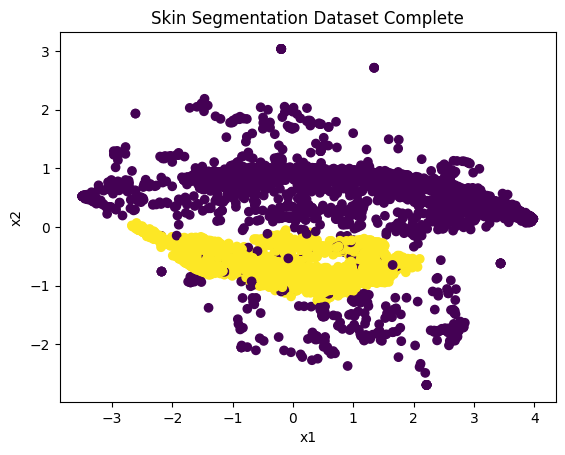

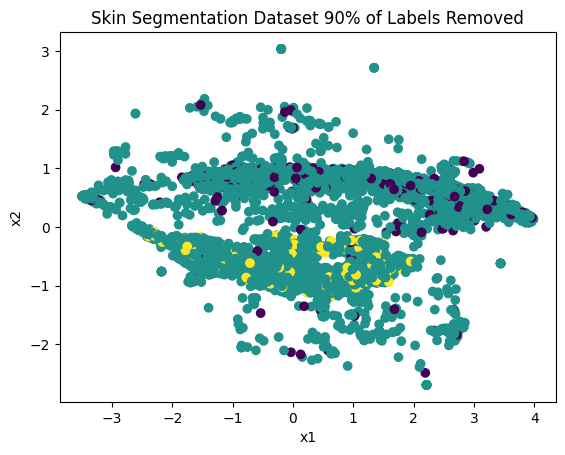

In [39]:
# Reset the class labels from (y = 1,2) to (y = -1,1)
y[y == 2] = -1

#standardization 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reduce dimensionality of x features using Principal Component Analysis (PCA)
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# Plot the 2D data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Skin Segmentation Dataset Complete')
plt.xlabel('x1')
plt.ylabel('x2')
#plt.savefig(output_dir + "/Skin Segmentation_Dataset_Original.png")
plt.show()

# Randomly remove 90% of labels
y_new = np.copy(y)
remove_idx = np.sort(np.random.choice(len(y), size=int(len(y)*90/100), replace=False))
y_unlabeled_target = y[remove_idx] # Save the removed labels for later use
y_new[remove_idx] = 0 # Set the removed labels to 0

# Split X into labeled (y = -1, 1) and unlabeled (y = 0) sets
labeled_idx = np.where(y_new != 0)
unlabeled_idx = np.where(y_new == 0)
x_labeled = X[labeled_idx]
x_unlabeled = X[unlabeled_idx]
y_labeled = y_new[labeled_idx]
y_unlabeled = y_new[unlabeled_idx]

# Plot the points with different colors according to their labels
plt.scatter(X[:, 0], X[:, 1], c=y_new, cmap='viridis')
plt.title('Skin Segmentation Dataset 90% of Labels Removed')
plt.xlabel('x1')
plt.ylabel('x2')
#plt.savefig(output_dir + "/Skin Segmentation_Dataset_Labels_Removed.png")
plt.show()

In [40]:
print("x unlabeled:",x_unlabeled.shape)
print("x labeled :",x_labeled.shape)
print("y unlabeled:",y_unlabeled.shape)
print("y labeled",y_labeled.shape)

x unlabeled: (9000, 2)
x labeled : (1000, 2)
y unlabeled: (9000,)
y labeled (1000,)


In [41]:
sigma = 0.3
# similarity matrix labeled-unlabeled
w_labeled_unlabeled = gaussian_similarity(x_labeled, x_unlabeled,sigma=sigma)

# similarity matrix unlabeled-unlabeled
w_unlabeled_unlabeled = gaussian_similarity(x_unlabeled, x_unlabeled,sigma=sigma)

In [42]:
# Define the Gradient Coefficients and Gradient
sumbycol_label_unlabel = np.sum(w_labeled_unlabeled, axis=0).reshape((-1,1))
sumbycol_unlabel_unlabel = np.sum(w_unlabeled_unlabeled, axis=0).reshape((-1,1))
grad_first_term = 2 * (sumbycol_label_unlabel + sumbycol_unlabel_unlabel)
grad_second_term = 2 * np.multiply(y_labeled.reshape((-1,1)), w_labeled_unlabeled).sum(0).reshape((-1,1))

In [43]:
hessian = hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled)

In [44]:
# Estimate the Lipschitz constant for this sigma value
L = estimate_lipschitz_constant(hessian)
    
# Compute the step size
step_size = 1 / L

# Print the Lipschitz constant and step size
print(f"Sigma: {sigma}")
print(f"Estimate of Lipschitz constant: {L}")
print(f"Step size: {step_size}\n")

Sigma: 0.3
Estimate of Lipschitz constant: 2484.01902369819
Step size: 0.00040257340642714046



In [45]:
# Define a Lipschitz constant for each unlabeled data point
Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64')

### Gradient Descent on Skin Segmentation Data

100%|██████████| 50/50 [04:55<00:00,  5.91s/it]



Final accuracy: 96.08%
F1-Score: 0.9622177030932249
Confusion Matrix:
[[4152  353]
 [   0 4495]]
Norm gradient: 840.0844416898537
Loss: 62906.17812766734



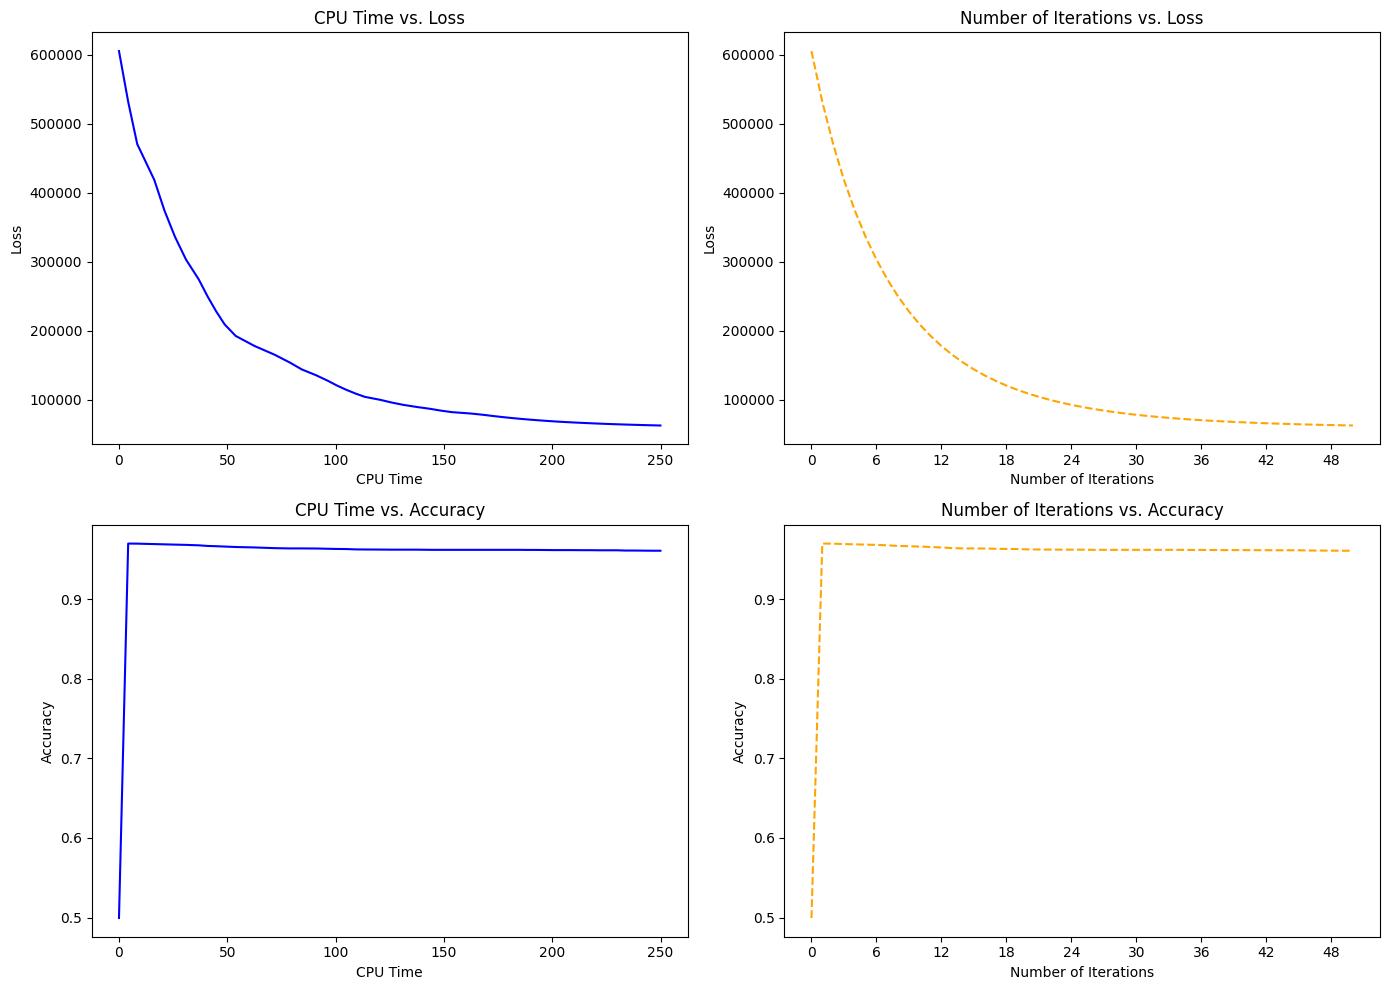

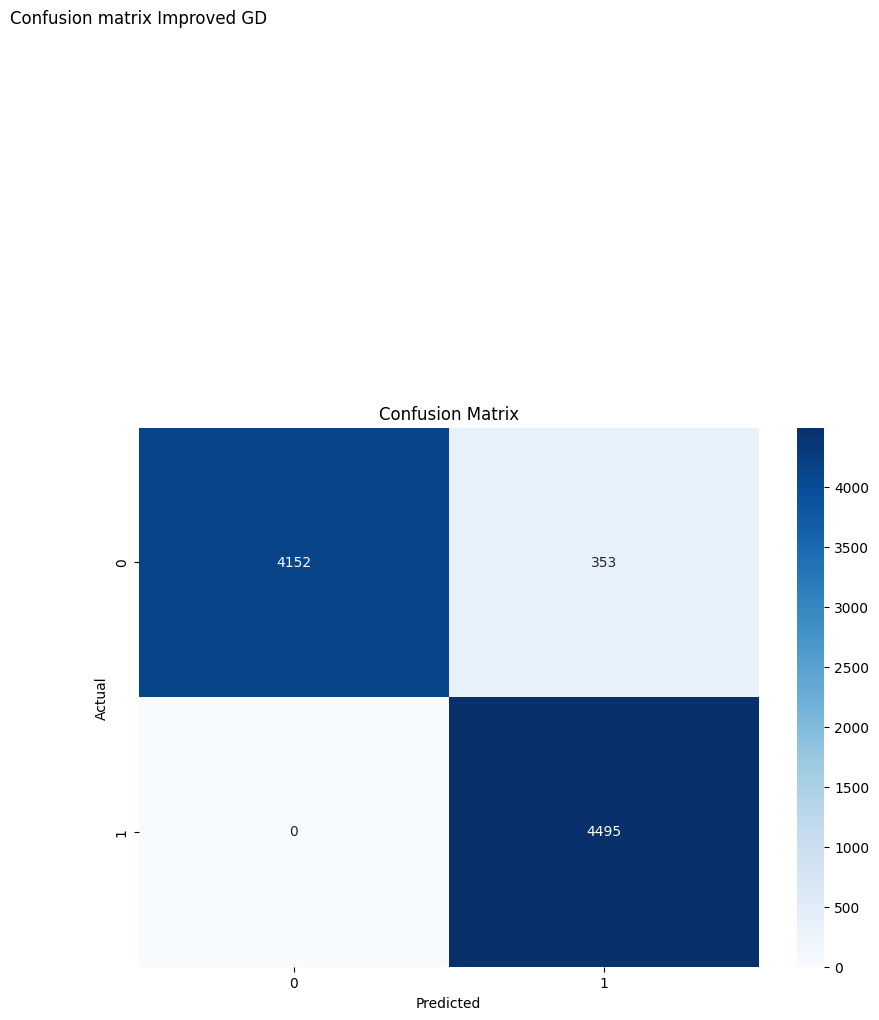

CPU times: user 3min 2s, sys: 1min 13s, total: 4min 15s
Wall time: 5min 2s


In [46]:
%%time

#Copy original unlabeled data
y_unlabeled_gd = np.copy(y_unlabeled).astype("float64")

current_time = time.strftime("%Y%m%d-%H%M%S")

num_iters = 50
epsilon = 1e-5
gd_accuracies = []
gd_losses = []
gd_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_gd)]
gd_losses = [loss(y_labeled, y_unlabeled_gd)]
cpu_times_gd = [0]

start_time_gd = time.process_time()  # Start measuring CPU time

for i in trange(num_iters):
    grad_array = gradient(y_unlabeled_gd)

    if epsilon >= np.linalg.norm(grad_array):
        print('We stopped at iteration{}'.format(i))
        break

    y_unlabeled_gd = y_unlabeled_gd - step_size * grad_array
    gd_accuracies.append(accuracy(y_unlabeled_target, y_unlabeled_gd))
    gd_losses.append(loss(y_labeled, y_unlabeled_gd))
    cpu_times_gd.append(time.process_time() - start_time_gd)  # Calculate elapsed CPU time for each iteration

y_unlabeled_gd_binary = np.where(y_unlabeled_gd >= 0, 1, -1)

print(f"""
Final accuracy: {round(gd_accuracies[-1] * 100, 2)}%
F1-Score: {f1_score(y_unlabeled_target, y_unlabeled_gd_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_gd_binary)}
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {gd_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_gd, gd_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(gd_losses)), gd_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_gd, gd_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(gd_accuracies)), gd_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"Skin_Gradient_Descent_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

# Calculate Confusion matrix
cm_gd = confusion_matrix(y_unlabeled_target, y_unlabeled_gd_binary)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_gd, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix Improved GD', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"Skin_Gradient_Descent_Confusion_Matrix_{current_time}.png"))
plt.show()

In [47]:
print(y_unlabeled_gd)
print(y_unlabeled_target)

[ 0.89492442  0.90603776 -0.95269914 ...  0.91058879  0.89751397
 -0.95297052]
[ 1.  1. -1. ... -1.  1. -1.]


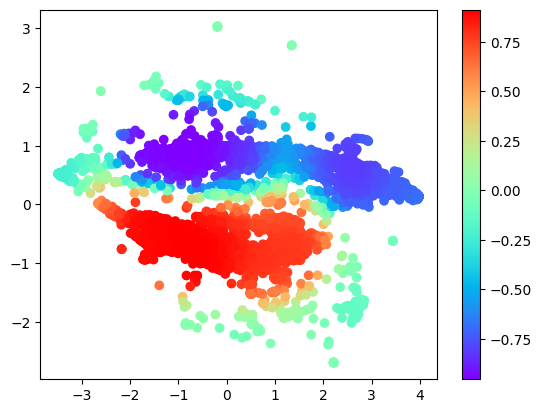

In [48]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_gd, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_GD_Training_y_unlabeled_gd.png")
plt.show()

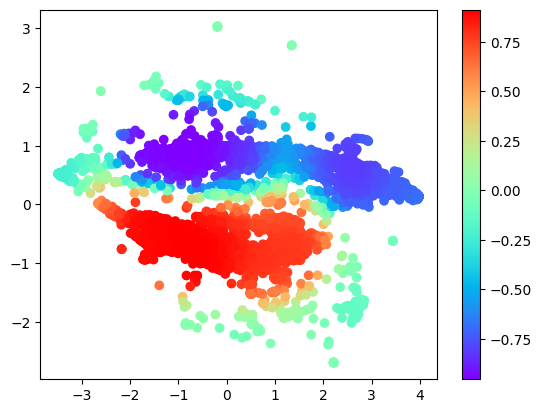

In [49]:
# Plot trained data against target
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_gd, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_GD_Training_y_unlabeled_target.png")
plt.show()

### Momentum-based gradient descent : Heavy Ball on Skin-Segmentation Data

100%|██████████| 50/50 [04:15<00:00,  5.11s/it]



Final accuracy: 96.08%
F1 Score: 0.9622177030932249
Confusion Matrix:
[[4152  353]
 [   0 4495]]
Norm gradient: 327.0614548179435
Loss: 58884.782426354504



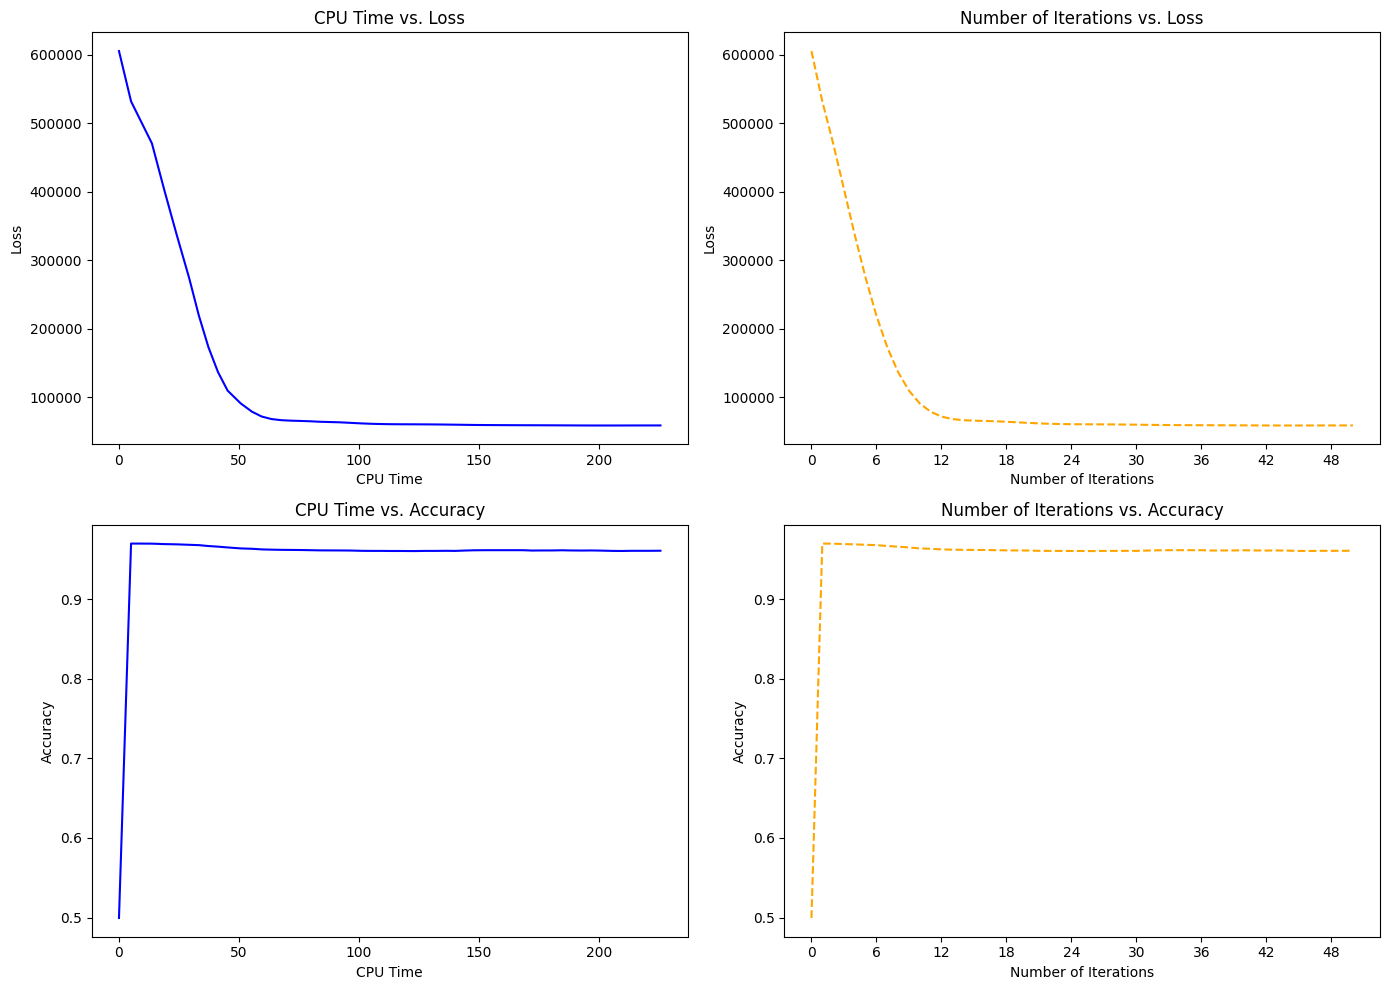

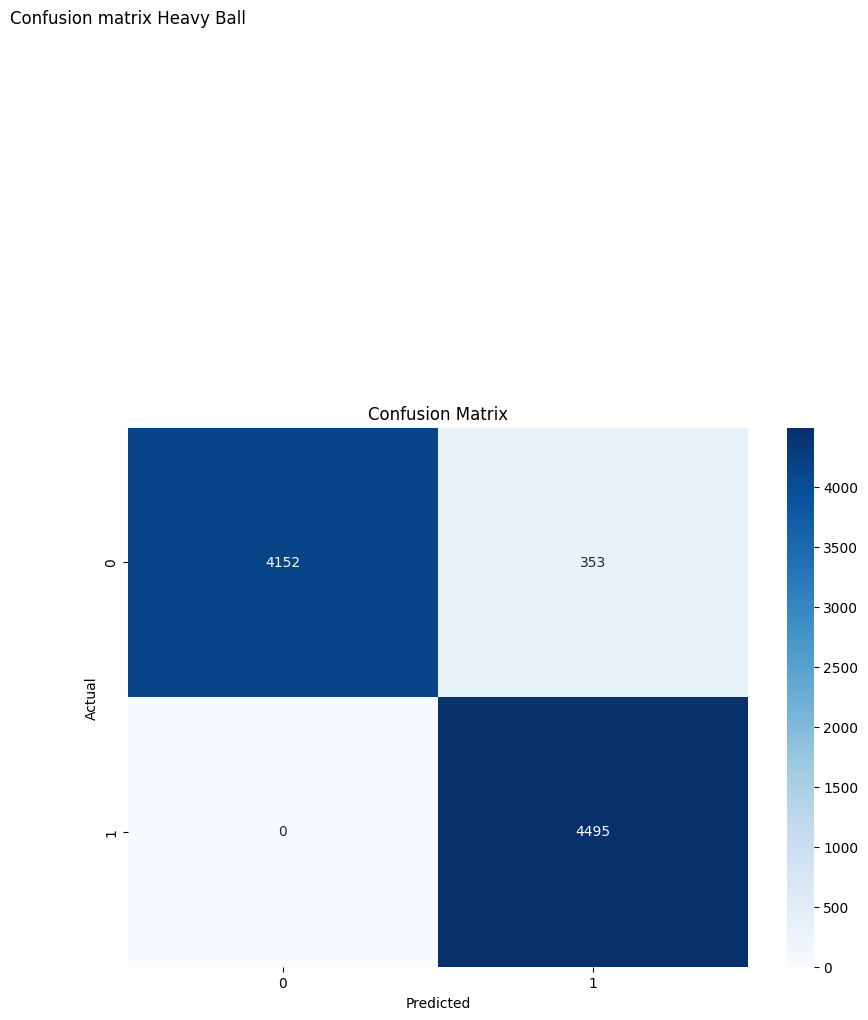

CPU times: user 2min 53s, sys: 56.8 s, total: 3min 50s
Wall time: 4min 20s


In [50]:
%%time

# Copy original unlabeled data
y_unlabeled_hb_previous = y_unlabeled_hb = np.copy(y_unlabeled)

current_time = time.strftime("%Y%m%d-%H%M%S")

step_size = step_size
num_iters = 50
epsilon = 1e-5
hb_accuracies = []
hb_losses = []
hb_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_hb)]
hb_losses = [loss(y_labeled, y_unlabeled_hb)]
hb_cpu_times = [0]

start_time = time.process_time()  # Start measuring CPU time
lambda_ = 0

for i in trange(num_iters):
    grad_array = gradient(y_unlabeled_hb)

    if epsilon >= np.linalg.norm(grad_array):
        print('We stopped at iteration{}'.format(i))
        break

    new_lambda_ = (1 + math.sqrt(1 + 4 * lambda_**2))/2
    Beta = (lambda_ - 1) / new_lambda_
    lambda_ = new_lambda_
    momentum = Beta * (y_unlabeled_hb - y_unlabeled_hb_previous)

    old_y_unlabeled_hb = np.copy(y_unlabeled_hb)
    y_unlabeled_hb = y_unlabeled_hb - step_size * grad_array + momentum
    y_unlabeled_hb_previous = old_y_unlabeled_hb

    hb_accuracies.append(accuracy(y_unlabeled_target, y_unlabeled_hb))
    hb_losses.append(loss(y_labeled, y_unlabeled_hb))
    hb_cpu_times.append(time.process_time() - start_time)  # Calculate elapsed CPU time for each iteration

# Compute accuracy score, f1 score and confusion matrix
accuracy_score = accuracy(y_unlabeled_target, y_unlabeled_hb)

y_unlabeled_hb_binary = np.where(y_unlabeled_hb >= 0, 1, -1)

print(f"""
Final accuracy: {round(accuracy_score * 100, 2)}%
F1 Score: {f1_score(y_unlabeled_target, y_unlabeled_hb_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_hb_binary)}
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_hb))}
Loss: {hb_losses[-1]}
""")

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

axs[0, 0].plot(hb_cpu_times, hb_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

axs[0, 1].plot(range(len(hb_losses)), hb_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axs[1, 0].plot(hb_cpu_times, hb_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

axs[1, 1].plot(range(len(hb_accuracies)), hb_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"Skin_Heavy_Ball_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

plt.tight_layout()
plt.show()

# Calculate Confusion matrix
cm_hb = confusion_matrix(y_unlabeled_target, y_unlabeled_hb_binary)

plt.figure(figsize=(10,7))
sns.heatmap(cm_hb, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix Heavy Ball', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"Skin_Heavy_Ball_Confusion_Matrix_{current_time}.png"))
plt.show()

In [51]:
print(y_unlabeled_hb)
print(y_unlabeled_target)

[ 0.91617389  0.93125153 -0.97353348 ...  0.93308533  0.92513652
 -0.97351987]
[ 1.  1. -1. ... -1.  1. -1.]


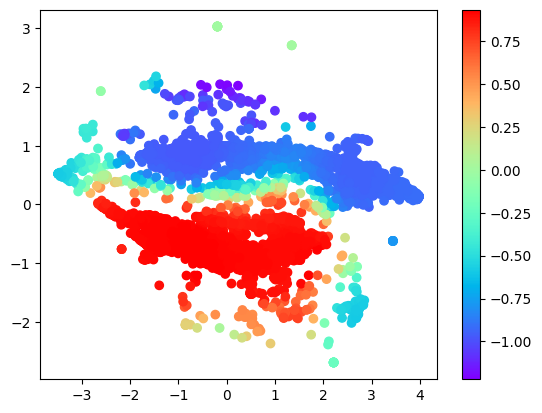

In [52]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_hb, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_HB_Training_y_unlabeled_hb.png")
plt.show()

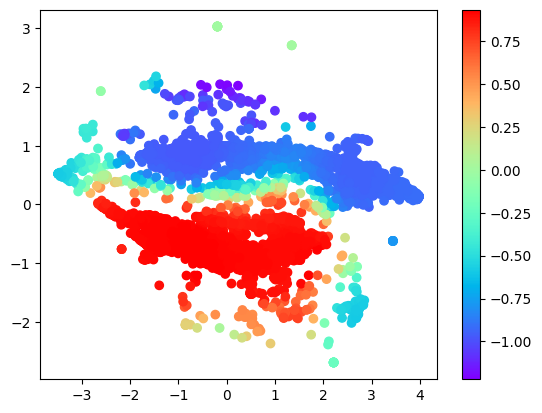

In [53]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_hb, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_HB_Training_y_unlabeled_hb.png")
plt.show()

### Block Coordinate Gradient Method: Randomized on Skin-Segmentation Data

100%|██████████| 450000/450000 [05:06<00:00, 1466.47it/s]



Final accuracy: 95.61%
F1 Score: 0.9579115610015982
Confusion Matrix:
[[4110  395]
 [   0 4495]]
Norm gradient: 449.3314572294224
Loss: 59243.85296987716



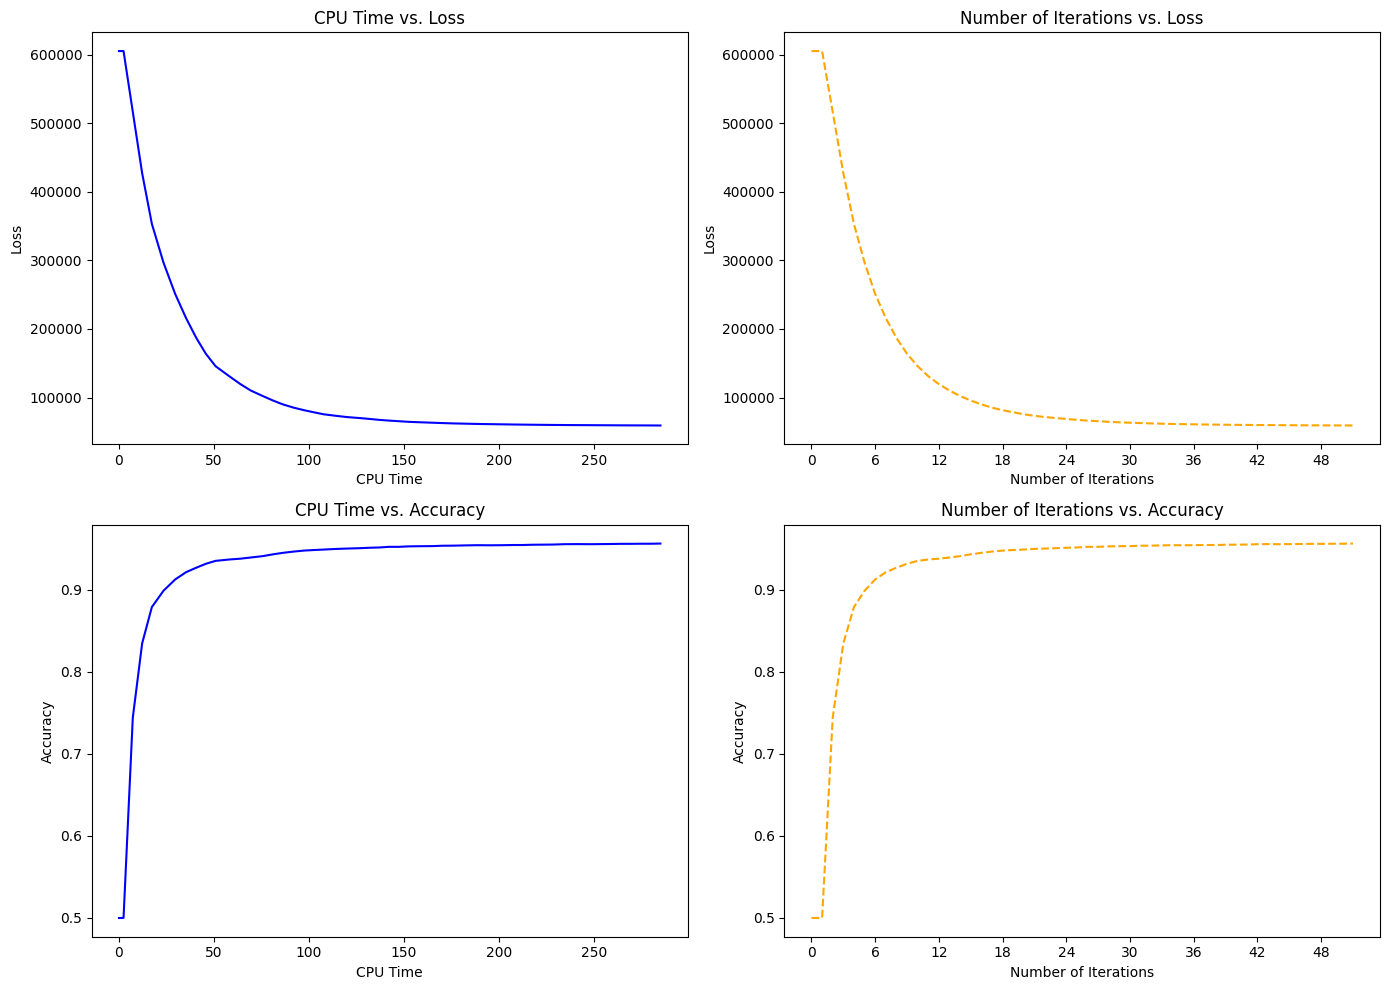

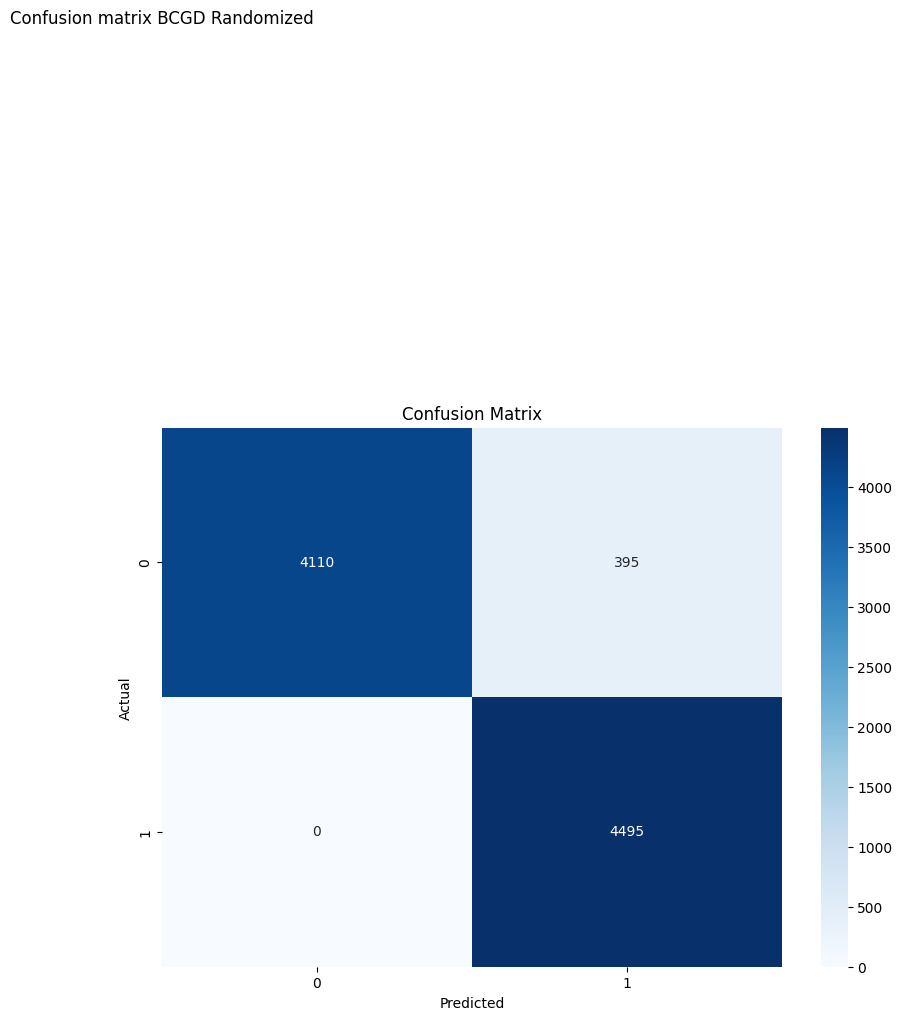

CPU times: user 3min 57s, sys: 51.9 s, total: 4min 49s
Wall time: 5min 15s


In [54]:
%%time

# Make a copy of the unlabeled data
y_unlabeled_bcgd_random = np.copy(y_unlabeled).astype(np.float64)
current_time = time.strftime("%Y%m%d-%H%M%S")
max_iter = num_iters * len(y_unlabeled_bcgd_random)

# Define the improved probability measure using the array of Lipschitz constants
improved_prob = Li / np.sum(Li)

grad_bcgd_rand = gradient(y_unlabeled_bcgd_random)
bcgd_rand_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)]
bcgd_rand_losses = [loss(y_labeled, y_unlabeled_bcgd_random)]

# Select a random index according to the improved probability measure
indices = np.random.choice(len(y_unlabeled_bcgd_random), max_iter, p=improved_prob)

start_time_bcgd_rand = time.process_time()  # Start measuring CPU time
cpu_times_bcgd_rand = [0]
for i in trange(max_iter):
    
    j = indices[i]
    
    # Calculate the gradient at the unlabeled data point with index j
    grad_j = grad_first_term[j] * y_unlabeled_bcgd_random[j] - \
             grad_second_term[j] - \
             2 * np.matmul(w_unlabeled_unlabeled[:,j], y_unlabeled_bcgd_random.T)

    # Replace the gradient of index j in the original gradient array
    grad_bcgd_rand[j] = grad_j

    # Update the unlabeled data point with index j
    y_unlabeled_bcgd_random[j] -= grad_j[0] / (Li[j])
    
    # Calculate accuracy and loss at each full length iteration
    if i % len(y_unlabeled_target) == 0:
        acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)
        loss_val = loss(y_labeled, y_unlabeled_bcgd_random)
        bcgd_rand_accuracies.append(acc)
        bcgd_rand_losses.append(loss_val)
        cpu_times_bcgd_rand.append(time.process_time() - start_time_bcgd_rand)

    # Check stopping condition
    grad_norm_rand = np.linalg.norm(grad_bcgd_rand)
    if grad_norm_rand <= epsilon:
        print(f"We stopped at iteration {i}")
        break

acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_random)
loss_val = loss(y_labeled, y_unlabeled_bcgd_random)
bcgd_rand_accuracies.append(acc)
bcgd_rand_losses.append(loss_val)
cpu_times_bcgd_rand.append(time.process_time() - start_time_bcgd_rand)  # Calculate elapsed CPU time for each iteration

y_unlabeled_bcgd_rand_binary = np.where(y_unlabeled_bcgd_random >= 0, 1, -1)

print(f"""
Final accuracy: {round(bcgd_rand_accuracies[-1] * 100, 2)}%
F1 Score: {f1_score(y_unlabeled_target,y_unlabeled_bcgd_rand_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_rand_binary)}
Norm gradient: {grad_norm_rand}
Loss: {bcgd_rand_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_bcgd_rand, bcgd_rand_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(bcgd_rand_losses)), bcgd_rand_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_bcgd_rand, bcgd_rand_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(bcgd_rand_accuracies)), bcgd_rand_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"Skin_BCGD_Randomized_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

# Calculate Confusion matrix
cm_bcgd_rand = confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_rand_binary)

plt.figure(figsize=(10,7))
sns.heatmap(cm_bcgd_rand, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix BCGD Randomized', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"Skin_BCGD_Randomized_Confusion_Matrix_{current_time}.png"))
plt.show()

In [55]:
print(y_unlabeled_bcgd_random)
print(y_unlabeled_target)

[ 0.92315043  0.93577894 -0.97599247 ...  0.93871798  0.92815606
 -0.97592269]
[ 1.  1. -1. ... -1.  1. -1.]


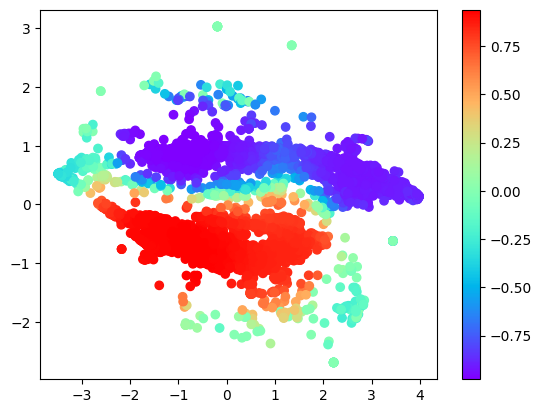

In [56]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_bcgd_random, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_bcgd_random_Training_y_unlabeled_bcgd_rand.png")
plt.show()

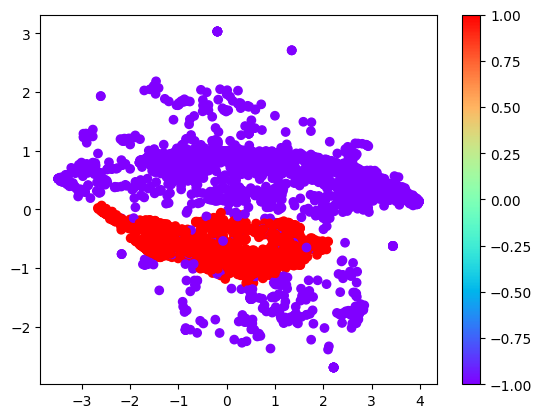

In [57]:
# Plot trained data against target
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_target, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_bcgd_random_Training_y_unlabeled_bcgd_target.png")
plt.show()

### Block Coordinate Gradient Method: Gauss-Southwell on Skin-Segmentation Data

In [58]:
#copy the unlabeled data to a new y_unlabeled_bcgd-gs array 
y_unlabeled_bcgd_gs = np.copy(y_unlabeled).astype("float64")

100%|██████████| 450000/450000 [03:52<00:00, 1936.58it/s]



Final accuracy: 96.06%
F1 Score: 0.962011771000535
Confusion Matrix:
[[4150  355]
 [   0 4495]]
Norm gradient: 0.23334726337863398
Loss: 58443.61306565623



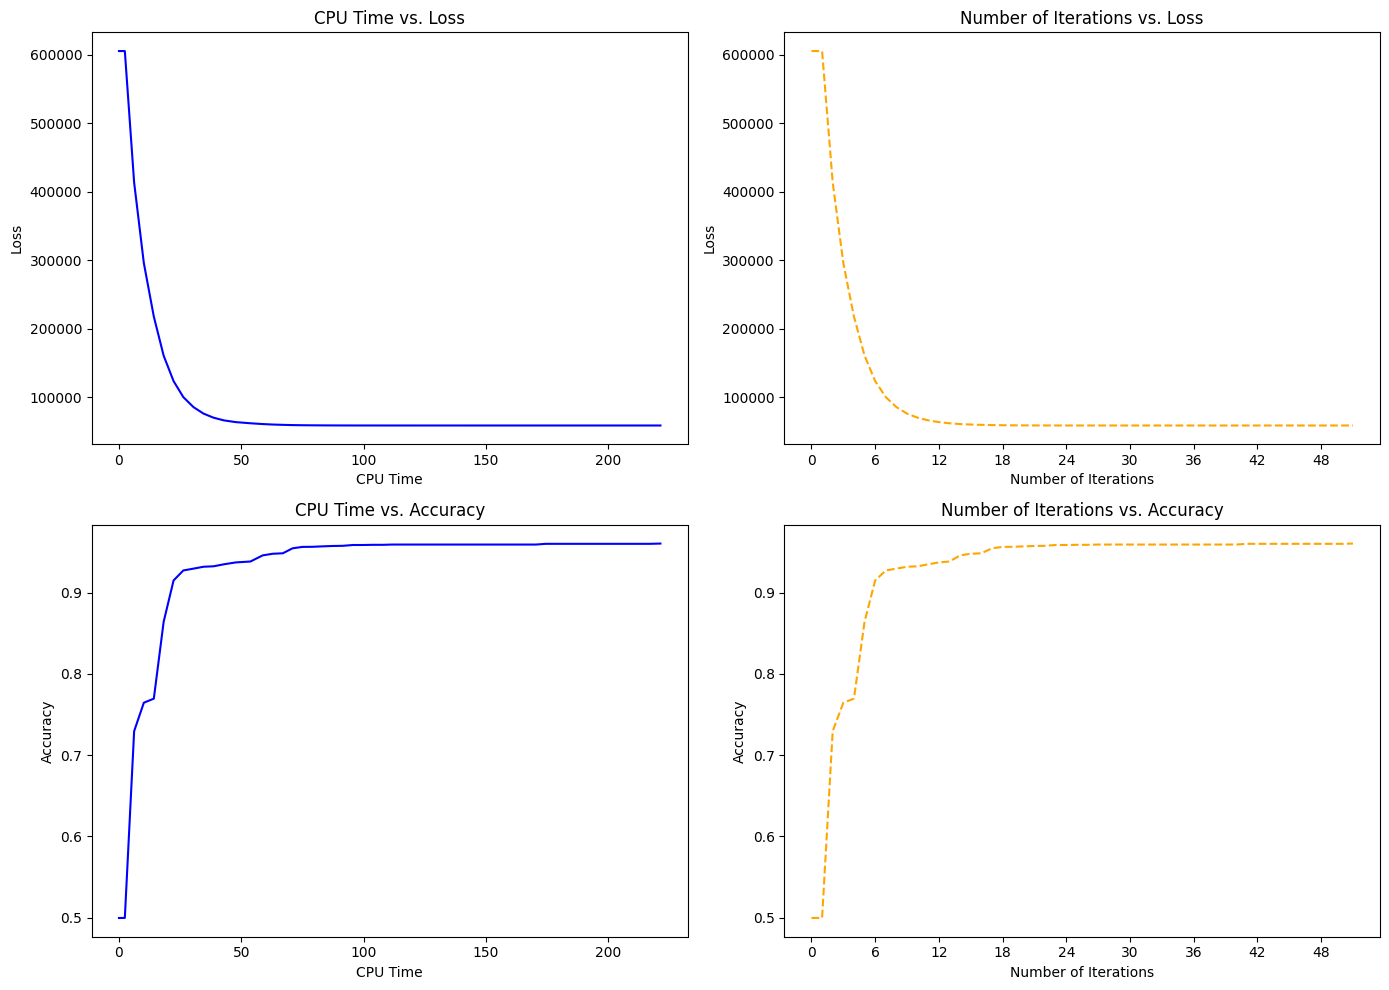

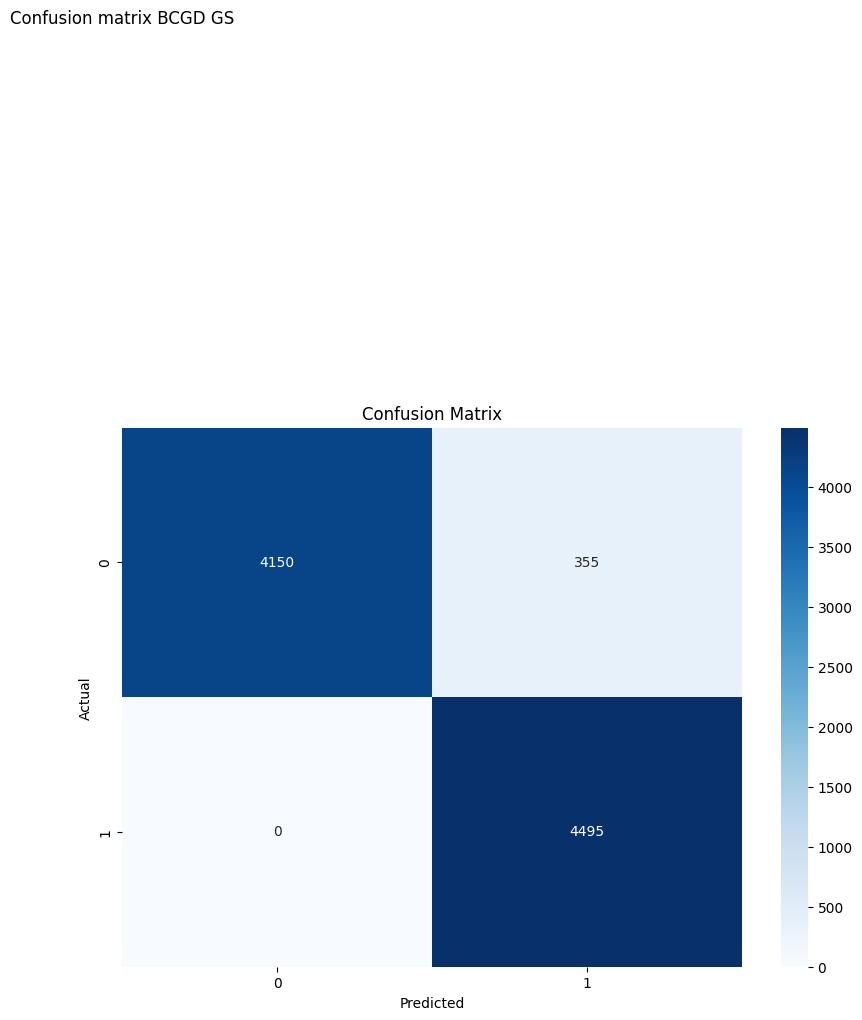

CPU times: user 3min 4s, sys: 41.8 s, total: 3min 46s
Wall time: 4min 1s


In [59]:
%%time

current_time = time.strftime("%Y%m%d-%H%M%S")

bcgd_gs_accuracies = [accuracy(y_unlabeled_target, y_unlabeled_bcgd_gs)]
bcgd_gs_losses = [loss(y_labeled, y_unlabeled_bcgd_gs)]
num_iters = 50
max_iter = num_iters*len(y_unlabeled_bcgd_gs)
bcgd_gs_grad_prev= gradient(y_unlabeled_bcgd_gs)

start_time_bcgd_gs = time.process_time()  # Start measuring CPU time
cpu_times_bcgd_gs = [0]

for i in trange(max_iter):

    # Select index 
    index = np.argmax(np.abs(bcgd_gs_grad_prev))

    update_step, bcgd_gs_grad =bcgd_gs_gradient(bcgd_gs_grad_prev, index, Li)
    
    y_unlabeled_bcgd_gs[index] =y_unlabeled_bcgd_gs[index] - update_step
    bcgd_gs_grad_prev=bcgd_gs_grad

    # Calculate accuracy and loss at each full length iteration
    if i % len(y_unlabeled_target) == 0:
        acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_gs)
        loss_val = loss(y_labeled, y_unlabeled_bcgd_gs)
        bcgd_gs_accuracies.append(acc)
        bcgd_gs_losses.append(loss_val)
        cpu_times_bcgd_gs.append(time.process_time() - start_time_bcgd_gs)

    grad_norm_gs = np.linalg.norm(bcgd_gs_grad_prev)
    if epsilon >= grad_norm_gs:
        print('We stopped at iteration{}'.format(i))
        break

acc = accuracy(y_unlabeled_target, y_unlabeled_bcgd_gs)
loss_val = loss(y_labeled, y_unlabeled_bcgd_gs)
bcgd_gs_accuracies.append(acc)
bcgd_gs_losses.append(loss_val)
cpu_times_bcgd_gs.append(time.process_time() - start_time_bcgd_gs)  # Calculate elapsed CPU time for each iteration

y_unlabeled_bcgd_gs_binary = np.where(y_unlabeled_bcgd_gs >= 0, 1, -1)

print(f"""
Final accuracy: {round(bcgd_gs_accuracies[-1] * 100, 2)}%
F1 Score: {f1_score(y_unlabeled_target,y_unlabeled_bcgd_gs_binary)}
Confusion Matrix:
{confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_gs_binary)}
Norm gradient: {grad_norm_gs}
Loss: {bcgd_gs_losses[-1]}
""")

# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color1 = "blue"
color2 = "orange"
linestyle1 = '-'    # Solid line
linestyle2 = '--'   # Dashed line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_bcgd_gs, bcgd_gs_losses, color=color1, linestyle=linestyle1)
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(bcgd_gs_losses)), bcgd_gs_losses, color=color2, linestyle=linestyle2)
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_bcgd_gs, bcgd_gs_accuracies, color=color1, linestyle=linestyle1)
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(bcgd_gs_accuracies)), bcgd_gs_accuracies, color=color2, linestyle=linestyle2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
#fig.savefig(os.path.join(output_dir, f"Skin_BCGD_GS_Loss_Accuracy_{num_iters}_sigma_{sigma}_{current_time}.png"))

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures
plt.show()

# Calculate Confusion matrix
cm_bcgd_gs = confusion_matrix(y_unlabeled_target, y_unlabeled_bcgd_gs_binary)

plt.figure(figsize=(10,7))
sns.heatmap(cm_bcgd_gs, annot=True, fmt='d', cmap='Blues')

plt.text(0, -1.5, 'Confusion matrix BCGD GS', fontsize=12, ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#plt.savefig(os.path.join(output_dir, f"Skin_BCGD_GS_Confusion_Matrix_{current_time}.png"))
plt.show()

In [60]:
print(y_unlabeled_bcgd_gs)
print(y_unlabeled_target)

[ 0.92639882  0.93940752 -0.98012865 ...  0.94197259  0.93276864
 -0.98014328]
[ 1.  1. -1. ... -1.  1. -1.]


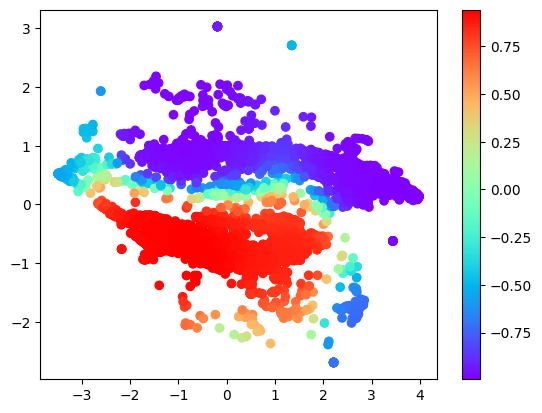

In [61]:
# Plot trained data against gradient
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_bcgd_gs, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_bcgd_gs_Training_y_unlabeled_bcgd_gs.png")
plt.show()

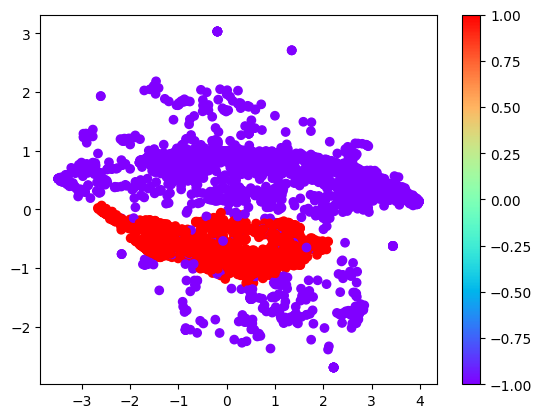

In [62]:
# Plot trained data against target
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c=y_unlabeled_target, cmap='rainbow')
plt.colorbar()
#plt.savefig(output_dir + "/Skin_Dataset_Post_bcgd_gs_Training_y_unlabeled_target.png")
plt.show()

### Compare all the models for the Skin Segmentation dataset

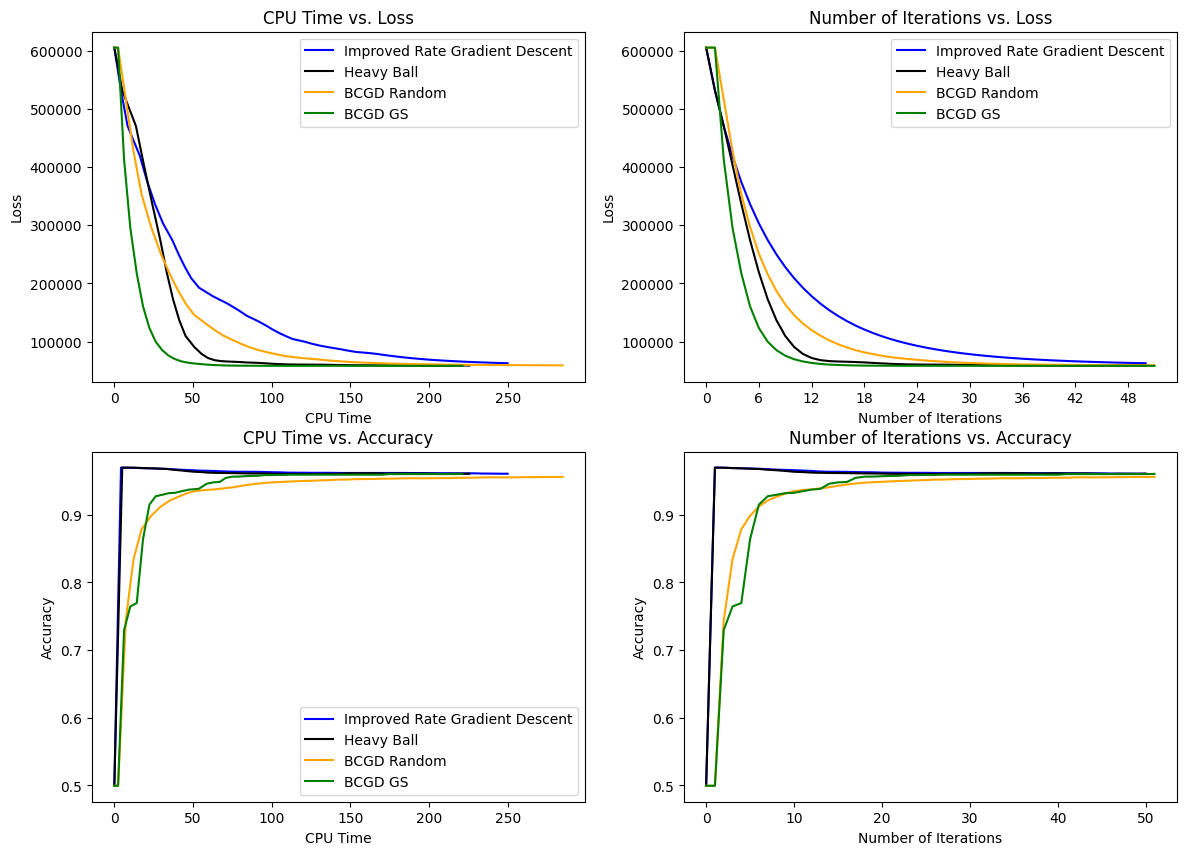

In [63]:
# Create a figure with a larger width
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Set some color and style constants
color_gd = "blue"
color_hb = "black"
color_bcgd_rand = "orange"
color_bcgd_gs = "green"
linestyle1 = '-'    # Solid line

# Plot the first figure: CPU time vs. loss
axs[0, 0].plot(cpu_times_gd, gd_losses, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[0, 0].plot(hb_cpu_times, hb_losses, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[0, 0].plot(cpu_times_bcgd_rand, bcgd_rand_losses, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[0, 0].plot(cpu_times_bcgd_gs, bcgd_gs_losses, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[0, 0].set_xlabel('CPU Time')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('CPU Time vs. Loss')
axs[0, 0].legend()

# Plot the second figure: Number of iterations vs. loss
axs[0, 1].plot(range(len(gd_losses)), gd_losses, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[0, 1].plot(range(len(hb_losses)), hb_losses, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[0, 1].plot(range(len(bcgd_rand_losses)), bcgd_rand_losses, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[0, 1].plot(range(len(bcgd_gs_losses)), bcgd_gs_losses, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[0, 1].set_xlabel('Number of Iterations')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Number of Iterations vs. Loss')
axs[0, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0, 1].legend()

# Plot the third figure: CPU time vs. accuracy
axs[1, 0].plot(cpu_times_gd, gd_accuracies, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[1, 0].plot(hb_cpu_times, hb_accuracies, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[1, 0].plot(cpu_times_bcgd_rand, bcgd_rand_accuracies, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[1, 0].plot(cpu_times_bcgd_gs, bcgd_gs_accuracies, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[1, 0].set_xlabel('CPU Time')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('CPU Time vs. Accuracy')
axs[1, 0].legend()

# Plot the fourth figure: Number of iterations vs. accuracy
axs[1, 1].plot(range(len(gd_accuracies)), gd_accuracies, color=color_gd, linestyle=linestyle1, label='Improved Rate Gradient Descent')
axs[1, 1].plot(range(len(hb_accuracies)), hb_accuracies, color=color_hb, linestyle=linestyle1, label='Heavy Ball')
axs[1, 1].plot(range(len(bcgd_rand_accuracies)), bcgd_rand_accuracies, color=color_bcgd_rand, linestyle=linestyle1, label='BCGD Random')
axs[1, 1].plot(range(len(bcgd_gs_accuracies)), bcgd_gs_accuracies, color=color_bcgd_gs, linestyle=linestyle1, label='BCGD GS')
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Number of Iterations vs. Accuracy')
axs[1, 1].xaxis
#fig.savefig(os.path.join(output_dir, f"Skin_Dataset_Compare_All_Models_{num_iters}_sigma_{sigma}_{current_time}.png"))


plt.show()